In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics
from ultralytics import YOLO
model = YOLO("yolo11n-pose.pt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 684.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

100%|██████████| 5.97M/5.97M [00:00<00:00, 167MB/s]


## Importing required libraries

In [ ]:
import os
import json
import numpy as np
import cv2
import time
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from scipy.ndimage import shift
from joblib import Parallel, delayed
import torch
import torchvision
import torchvision.models.detection as detection
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, LeaveOneGroupOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
import math

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Ground truth data function
This function creates a dataframe that stores the paths (features, keypoints, silhouettes) for each video sample and the activity performed. It also divides the entire dataset into 3 folds for 3 fold validation

In [ ]:

# Data directories
DATA_DIR = '/content/drive/MyDrive/FYP/Dataset'
KEYPOINTS_DIR = '/content/drive/MyDrive/FYP/keypoints'
SILHOUETES_DIR = '/content/drive/MyDrive/FYP/Silhouetes'
HOF_DIR = '/content/drive/MyDrive/FYP/HOF'
DIST_DIR = '/content/drive/MyDrive/FYP/Dist'
ANGLE_DIR = '/content/drive/MyDrive/FYP/Angle'
LTP_DIR = '/content/drive/MyDrive/FYP/LTP'
VELOCITY_DIR = '/content/drive/MyDrive/FYP/Velocity'

os.makedirs(KEYPOINTS_DIR, exist_ok=True)
os.makedirs(SILHOUETES_DIR, exist_ok=True)
os.makedirs(HOF_DIR, exist_ok=True)
os.makedirs(DIST_DIR, exist_ok=True)
os.makedirs(ANGLE_DIR, exist_ok=True)
os.makedirs(LTP_DIR, exist_ok=True)
os.makedirs(VELOCITY_DIR, exist_ok=True)

NUM_FOLDS = 3

# Function to get ground truth data
def get_ground_truth(num_folds=NUM_FOLDS, random_state=42):
    video_path_lst, video_lst, action_lst, keypoints_lst, silhouettes_lst, hof_lst, dist_lst, angle_lst, ltp_lst, vel_lst = [], [], [], [], [], [], [], [], [], []

    for video in os.listdir(DATA_DIR):
        video_name, _ = os.path.splitext(video)
        video_id, action = video_name.split('_')

        keypoints_path = os.path.join(KEYPOINTS_DIR, f'{video_name}.json')
        hof_path = os.path.join(HOF_DIR, f'{video_name}.npy')
        dist_path = os.path.join(DIST_DIR, f'{video_name}.npy')
        angle_path = os.path.join(ANGLE_DIR, f'{video_name}.npy')
        ltp_path = os.path.join(LTP_DIR, f'{video_name}.npy')
        vel_path = os.path.join(VELOCITY_DIR, f'{video_name}.npy')

        silhouettes_path = os.path.join(SILHOUETES_DIR, video_name)
        video_path = os.path.join(DATA_DIR, video)

        video_lst.append(video_name)
        action_lst.append(int(action) - 1)
        keypoints_lst.append(keypoints_path)
        silhouettes_lst.append(silhouettes_path)
        video_path_lst.append(video_path)
        hof_lst.append(hof_path)
        dist_lst.append(dist_path)
        angle_lst.append(angle_path)
        ltp_lst.append(ltp_path)
        vel_lst.append(vel_path)

    dataframe_dict = {'video_id': video_lst,
                      'action': action_lst,
                      'keypoints_path': keypoints_lst,
                      'silhouettes_path': silhouettes_lst,
                      'video_path': video_path_lst,
                      'hof_path': hof_lst,
                      'dist_path': dist_lst,
                      'angle_path': angle_lst,
                      'ltp_path': ltp_lst,
                      'vel_path': vel_lst}

    ground_truth = pd.DataFrame(dataframe_dict)
    ground_truth = ground_truth.set_index('video_id')

    # K-Fold
    skf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    ground_truth['fold'] = -1
    X = ground_truth.index.values
    y = ground_truth['action'].values

    for fold_idx, (_, val_idx) in enumerate(skf.split(X, y)):
        ground_truth.loc[ground_truth.index[val_idx], 'fold'] = fold_idx

    return ground_truth

gt = get_ground_truth()
print(gt)


          action                                  keypoints_path  \
video_id                                                           
1_2            1   /content/drive/MyDrive/FYP/keypoints/1_2.json   
2_2            1   /content/drive/MyDrive/FYP/keypoints/2_2.json   
3_2            1   /content/drive/MyDrive/FYP/keypoints/3_2.json   
4_2            1   /content/drive/MyDrive/FYP/keypoints/4_2.json   
16_1           0  /content/drive/MyDrive/FYP/keypoints/16_1.json   
...          ...                                             ...   
90_2           1  /content/drive/MyDrive/FYP/keypoints/90_2.json   
91_1           0  /content/drive/MyDrive/FYP/keypoints/91_1.json   
92_3           2  /content/drive/MyDrive/FYP/keypoints/92_3.json   
93_2           1  /content/drive/MyDrive/FYP/keypoints/93_2.json   
94_1           0  /content/drive/MyDrive/FYP/keypoints/94_1.json   

                                    silhouettes_path  \
video_id                                               
1_2

## Segmentation
This code iterates through each video in the dataset, extracts the gray scale silhouettes of the middle 61 frames using a pre trained MASK R-CNN model and then stores the silhouettes in their appropriate google drive location.

In [ ]:

def silhouette_extraction(frame, prediction):
    new_width = 480
    new_height = 320
    resized_frame = cv2.resize(frame, (new_width, new_height))
    gray_image = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    masks_image = np.zeros_like(gray_image, dtype=np.uint8)

    masks = prediction['masks']

    # Loop through masks, assuming person class index is 1
    for i in range(masks.shape[0]):
        if prediction['labels'][i] == 1 and prediction['scores'][i] > 0.5:
            mask = masks[i].cpu().numpy().squeeze()
            masks_image[mask > 0.4] = 1

    return gray_image * masks_image

def process_frames(video_path, silhouette_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # middle 61 frames were selected for segmentation to later on test with different no frames for best accuracy
    selected_frames = 61
    half_frames = total_frames // 2
    middle_starting_frame = max(0, min(half_frames - selected_frames // 2, total_frames - selected_frames))
    middle_ending_frame = middle_starting_frame + selected_frames
    batch_size = 8
    silhouette_paths = []
    tensor_frames = []
    frames = []
    j = 0

    # Read frames from the video
    for frame_no in range(middle_starting_frame, middle_ending_frame):
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)

        # Read the current frame from the video
        ret, frame = cap.read()

        if not ret:
            raise ValueError(f"Failed to read frame {frame_no} from the video!")

        # Set frame and silhouette paths
        silhouettes_path = os.path.join(silhouette_path, f"{frame_no}.png")

        # Check if silhouette exists already
        if os.path.exists(silhouettes_path):
            print(f"Silhouette {silhouettes_path} already exists")
        else:
            silhouette_paths.append(silhouettes_path)
            frames.append(frame)  # Adding the frame name to paths (not using full path for video frames)

            # Resize the frame (480x320) and convert it to RGB
            new_width = 480
            new_height = 320
            resized_frame = cv2.resize(frame, (new_width, new_height))
            resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

            # Transform to tensor
            transform = torchvision.transforms.ToTensor()
            resized_frame = transform(resized_frame).unsqueeze(0)  # Add batch dimension

            # Append the tensor to the list
            tensor_frames.append(resized_frame)

    cap.release()

    batches = []

    for i in range(0, len(tensor_frames), batch_size):
        batch = tensor_frames[i:i+batch_size]
        batch = torch.cat(batch, dim=0)
        batches.append(batch.to(device))  # Move batch to GPU

    for batch_no, batch in enumerate(batches):
        with torch.no_grad():
          predictions = model(batch)

        # Iterate over predictions and corresponding frame information
        for i in range(len(batch)):
          prediction = predictions[i]  # Access prediction for the current frame

          # Extract silhouettes
          silhouette = silhouette_extraction(frames[j], prediction)

          # Save silhouettes
          cv2.imwrite(silhouette_paths[j], silhouette)
          print(f"Processed frame: {silhouette_paths[j]}")

          j = j + 1

if __name__ == "__main__":
    # Load a pre-trained Mask R-CNN model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
    model.to(device)  # Move the model to GPU
    model.eval()

    video_df = get_ground_truth()

    for video, video_row in video_df.iterrows():
        process_frames(video_row['video_path'], video_row['silhouettes_path'])

## Keypoints extraction
This code extracts the keypoints from all the videos in the dataset, by first dividing each video into frames and then using pretrained YOLO 11n Pose model for keypoints detection. The keypoints for each frame are saved with track ids in json files.

In [ ]:
# specific indexes of keypoints to retain
SPECIFIC_INDEXES = [0, 5, 6, 7, 8, 9, 10]

# Function to process videos and store tracked keypoints in JSON files
def process_videos(video_dir, json_dir):
    # Ensure the JSON directory exists
    os.makedirs(json_dir, exist_ok=True)

    # Loop through all video files in the provided directory
    for video_filename in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_filename)
        # Save the tracked keypoints to a JSON file with the same name as the video
        json_filename = os.path.splitext(video_filename)[0] + ".json"
        json_path = os.path.join(json_dir, json_filename)

        if os.path.exists(json_path):
            continue

        # Skip non-video files
        if not video_filename.lower().endswith(('.mp4', '.mov', '.avi')):
            continue

        print("processing video ", video_path)
        # Open the video file
        cap = cv2.VideoCapture(video_path)
        vid_tracked_keypoints = {}  # Dictionary to store tracked keypoints per frame

        # Get the total number of frames in the video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Create a new tracker instance for this video
        model = YOLO("/content/yolo11n-pose.pt")  # Load the model again for each video

        # Loop through the middle 70 frames
        for frame_num in range(0, total_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            success, frame = cap.read()

            if not success:
                break

            # Run YOLOv11 tracking on the frame
            results = model.track(frame, persist=True, max_det=2, classes=[0], verbose=False, device="cpu")

            # Extract keypoints and track IDs from the results
            keypoints = results[0].keypoints.data
            track_ids = results[0].boxes.id.int().cpu().tolist()

            # Initialize dictionary to store the tracked keypoints for this frame
            frame_tracked_keypoints = {}

            # Ensure there are exactly 2 people detected in the frame
            if len(track_ids) != 2:
                raise ValueError(f"Expected 2 persons, but found {len(track_ids)} persons in frame {frame_num}.")

            # Iterate over each person's keypoints
            for person_data, track in zip(keypoints, track_ids):
                person_keypoints = []
                for index in SPECIFIC_INDEXES:
                    x, y, conf = person_data[index].tolist()
                    person_keypoints.append([x, y])

                # Store the tracked keypoints for this person
                frame_tracked_keypoints[track] = person_keypoints

            # Store the tracked keypoints for this frame
            vid_tracked_keypoints[frame_num] = frame_tracked_keypoints

        with open(json_path, 'w') as json_file:
            json.dump(vid_tracked_keypoints, json_file, indent=4)

        cap.release()

    print("Video processing complete!")

# usage
video_dir = '/content/drive/MyDrive/FYP/Dataset'  # path where videos are stored
json_dir = '/content/drive/MyDrive/FYP/keypoints'  # path where JSON files will be saved
process_videos(video_dir, json_dir)


## Histogram of optical flow (HOF) features extraction
This code extracts HOF features from the gray scale silhouettes and then saves them.

In [ ]:

def extract_hof_features(prev_frame, curr_frame):
    # Calculate the dense optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(prev_frame, curr_frame, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2,
                                        flags=0)

    # Compute magnitude and angle of the flow vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)

    # Bin the angles into 8 bins
    num_bins = 18
    bin_edges = np.linspace(0, 360, num_bins + 1)
    hof_features = np.histogram(angle, bins=bin_edges, weights=magnitude, density=True)[0]

     # Avoid NaNs by replacing them with zeros
    hof_features[np.isnan(hof_features)] = 0
    return hof_features

def process_frames_for_hof(video_silhouettes_path, target_hof_features_path):

    silhouettes = os.listdir(video_silhouettes_path)
    sorted_silhouettes = sorted(silhouettes, key=lambda x: int(x.split('.')[0]))
    hof_features_list = []

    for i in range(1, len(sorted_silhouettes)):  # Start from the second frame

        curr_silhouette_path = os.path.join(video_silhouettes_path, sorted_silhouettes[i])
        prev_silhouette_path = os.path.join(video_silhouettes_path, sorted_silhouettes[i-1])

        curr_silhouette = cv2.imread(curr_silhouette_path, cv2.IMREAD_GRAYSCALE)
        prev_silhouette = cv2.imread(prev_silhouette_path, cv2.IMREAD_GRAYSCALE)

        # Extract HOF features between current and previous silhouette
        hof_features = extract_hof_features(prev_silhouette, curr_silhouette)

        hof_features_list.append(hof_features)

    hof_features_list = np.array(hof_features_list)

    print(hof_features_list.shape)

    if hof_features_list.shape == (0, ):
        raise ValueError("No HOF features extracted")

    np.save(target_hof_features_path, hof_features_list)


if __name__ == "__main__":
    video_df = get_ground_truth()

    for video, video_row in video_df.iterrows():
        print("Processing video" , video)

        if os.path.exists(video_row['hof_path']):
            print(f"hof features file {video_row['hof_path']} exists already")
            continue

        process_frames_for_hof(video_row['silhouettes_path'], video_row['hof_path'])



## Local ternary pattern (LTP) features extraction
This code extracts the LTP features from the gray scale silhouettes and saves them.

In [ ]:

def compute_ltp(image, radius=1, neighbors=8, threshold=5):
    """
    Compute Local Ternary Patterns (LTP) for a grayscale image efficiently.
    Uses NumPy vectorized operations and SciPy shift to improve speed.
    """
    image = image.astype(np.float32)
    padded_image = cv2.copyMakeBorder(image, radius, radius, radius, radius, cv2.BORDER_REFLECT)

    h, w = image.shape
    ltp_pos = np.zeros((h, w), dtype=np.uint8)
    ltp_neg = np.zeros((h, w), dtype=np.uint8)

    offsets = [
        (int(np.round(radius * np.sin(2 * np.pi * n / neighbors))),
         int(np.round(radius * np.cos(2 * np.pi * n / neighbors))))
        for n in range(neighbors)
    ]

    # Create stacked neighbor shifts
    neighbors_matrix = np.stack([
        shift(padded_image, shift=(dy, dx), mode='nearest')[radius:-radius, radius:-radius]
        for dy, dx in offsets
    ], axis=-1)  # Shape: (h, w, neighbors)

    center_matrix = image[..., None]  # Shape: (h, w, 1)
    diff = neighbors_matrix - center_matrix  # Compute differences

    # Compute LTP codes using NumPy boolean indexing (Vectorized)
    ltp_pos = np.sum((diff > threshold) * (1 << np.arange(neighbors)), axis=-1, dtype=np.uint8)
    ltp_neg = np.sum((diff < -threshold) * (1 << np.arange(neighbors)), axis=-1, dtype=np.uint8)

    return ltp_pos, ltp_neg


def extract_ltp_feat_for_frame(image, radius=1, neighbors=8, threshold=5):
    """
    Extract LTP histogram features efficiently.
    """
    ltp_pos, ltp_neg = compute_ltp(image, radius, neighbors, threshold)

    # Compute histograms efficiently
    pos_hist = np.bincount(ltp_pos.ravel(), minlength=256)
    neg_hist = np.bincount(ltp_neg.ravel(), minlength=256)

    # Concatenate histograms and convert to float32
    return np.concatenate((pos_hist, neg_hist)).astype(np.float32)


def ltp_feat_extraction(video_silhouettes_path, target_ltp_features_path):
    """
    Process silhouette frames and extract LTP features in parallel.
    """
    silhouettes = os.listdir(video_silhouettes_path)
    silhouettes = sorted(silhouettes, key=lambda x: int(x.split('.')[0]))
    silhouettes = silhouettes[1:]
    # Use Joblib for parallel processing
    ltp_features = Parallel(n_jobs=-1)(
        delayed(extract_ltp_feat_for_frame)(
            cv2.imread(os.path.join(video_silhouettes_path, silhouette_path), cv2.IMREAD_GRAYSCALE)
            ) for silhouette_path in silhouettes
    )

    ltp_features = np.array(ltp_features)

    print(ltp_features.shape)
    if ltp_features.shape == (0, ):
        raise ValueError("No LTP features extracted")

    np.save(target_ltp_features_path, ltp_features)


if __name__ == "__main__":
    video_df = get_ground_truth()  # Ensure this function provides video data paths and output locations

    for video, video_row in video_df.iterrows():
        print("Processing video no:", video)

        if os.path.exists(video_row['ltp_path']):
            print(f"LTP features file {video_row['ltp_path']} already exists")
            continue

        ltp_feat_extraction(video_row['silhouettes_path'], video_row['ltp_path'])


## Distance features extraction
This code extracts the distance features from the person keypoints. First it creates intra and inter distance mapping and then uses it to extract distance features from specific keypoints using a formula.

In [ ]:

# Indices and mapping as provided
indices = {
    'N1': 0, 'LS1': 1, 'RS1': 2, 'LE1': 3, 'RE1': 4,
    'LW1': 5, 'RW1': 6,
    'N2': 0, 'LS2': 1, 'RS2': 2, 'LE2': 3, 'RE2': 4,
    'LW2': 5, 'RW2': 6,
}

intra_distance_mapping = {
    "N1": ["RW1"],
    "LS1": ["LW1"],
    "RE1": ["RW1"],
    "LE1": ["LW1"],

     "N2": ["RW2"],
    "LS2": ["LW2"],
    "RE2": ["RW2"],
    "LE2": ["LW2"],
}

inter_distance_mapping = {
    "LS1": ["RS2"],
    "LW1": ["RW2"],
    "LE1": ["RE2"],
    "N1": ["N2"],
}

# Function to compute distances
def compute_distance_changes(input_file, output_file):
    # Load keypoints from JSON
    with open(input_file, 'r') as f:
        keypoints = json.load(f)

    sorted_frames = sorted(keypoints.keys(), key=lambda x: int(x))

    total_frames = len(sorted_frames)

    # Calculate the start and end indices for the middle 60 frames
    start_index = max((total_frames - 60) // 2, 0)  # Ensure index is non-negative
    end_index = start_index + 60

    # Select the middle 60 frames
    sorted_frames = sorted_frames[start_index:end_index]

    intra_inter_distances = []

    for frame in sorted_frames:
        coords = keypoints[frame]
        # Identify left and right persons based on x-coordinates of their noses
        left_person_id, right_person_id = sorted(
            coords.keys(),
            key=lambda pid: coords[pid][0][0]
        )

        frame_intra_distances = []
        frame_inter_distances = []

        # Iterate through intra-person distances
        for joint_name, target_joints in intra_distance_mapping.items():
            if joint_name[-1] == "1":
                person_id = left_person_id
            else:
                person_id = right_person_id

            joint_idx = indices[joint_name]
            for target_joint in target_joints:
                target_joint_idx = indices[target_joint]
                try:
                    euclidean_distance = np.linalg.norm(
                        np.array(coords[person_id][joint_idx]) -
                        np.array(coords[person_id][target_joint_idx])
                    )
                    frame_intra_distances.append(euclidean_distance)
                except IndexError:
                    print("Error")
                    continue

        # Iterate through inter-person distances
        for joint_name, target_joints in inter_distance_mapping.items():
            if joint_name[-1] == "1":
                joint_person_id = left_person_id
            else:
                joint_person_id = right_person_id

            joint_idx = indices[joint_name]
            for target_joint in target_joints:
                if target_joint[-1] == "1":
                    target_person_id = left_person_id
                else:
                    target_person_id = right_person_id

                target_joint_idx = indices[target_joint]
                try:
                    euclidean_distance = np.linalg.norm(
                        np.array(coords[joint_person_id][joint_idx]) -
                        np.array(coords[target_person_id][target_joint_idx])
                    )
                    frame_inter_distances.append(euclidean_distance)
                except IndexError:
                    raise ValueError("Error")

        combined_distances = frame_intra_distances + frame_inter_distances
        intra_inter_distances.append(combined_distances)

    intra_inter_distances = np.array(intra_inter_distances)

    print("shape", intra_inter_distances.shape)

    np.save(output_file, intra_inter_distances)


if __name__ == "__main__":
    video_df = get_ground_truth()

    for video, video_row in video_df.iterrows():
        print("Processing video no:", video)

        if os.path.exists(video_row['dist']):
            print(f"distance change file {video_row['dist']} exists already")
            continue

        compute_distance_changes(video_row['keypoints_path'], video_row['dist_path'])


## Angle features extraction
This code extracts the angle features from the person keypoints. First it creates intra and inter angle mapping and then uses it to extract angle features from specific keypoints using a formula.

In [ ]:

# Indices and mapping as provided
indices = {
    'N1': 0, 'LS1': 1, 'RS1': 2, 'LE1': 3, 'RE1': 4,
    'LW1': 5, 'RW1': 6,
    'N2': 0, 'LS2': 1, 'RS2': 2, 'LE2': 3, 'RE2': 4,
    'LW2': 5, 'RW2': 6,
}

intra_angle_mapping = {
    "N1": ["RS1", "LS1"],
    "RS1": ["RE1"],
    "LS1": ["LE1"],
    "RE1": ["RW1"],
    "LE1": ["LW1"],

    "N2": ["RS2", "LS2"],
    "RS2": ["RE2"],
    "LS2": ["LE2"],
    "RE2": ["RW2"],
    "LE2": ["LW2"]

}

inter_angle_mapping = {
    "LW1": ["RW2"],
    "LE1": ["RE2"],
    "LS1": ["RS1"]
}


# Function to compute angles
def compute_angle_changes(input_file, output_file):
    # Load keypoints from JSON
    with open(input_file, 'r') as f:
        keypoints = json.load(f)

    sorted_frames = sorted(keypoints.keys(), key=lambda x: int(x))

    total_frames = len(sorted_frames)

    # Calculate the start and end indices for the middle 60 frames
    start_index = max((total_frames - 60) // 2, 0)  # Ensure index is non-negative
    end_index = start_index + 60

    # Select the middle 60 frames
    sorted_frames = sorted_frames[start_index:end_index]

    intra_inter_angles = []

    for frame in sorted_frames:
        coords = keypoints[frame]
        # Identify left and right persons based on x-coordinates of their noses
        left_person_id, right_person_id = sorted(
            coords.keys(),
            key=lambda pid: coords[pid][0][0]
        )

        frame_intra_angles = []
        frame_inter_angles = []

        # Iterate through intra-person angles
        for joint_name, target_joints in intra_angle_mapping.items():
            if joint_name[-1] == "1":
                person_id = left_person_id
            else:
                person_id = right_person_id

            joint_idx = indices[joint_name]
            for target_joint in target_joints:
                target_joint_idx = indices[target_joint]
                try:
                    delta_x = coords[person_id][target_joint_idx][0] - coords[person_id][joint_idx][0]
                    delta_y = coords[person_id][target_joint_idx][1] - coords[person_id][joint_idx][1]
                    angle = np.arctan2(delta_y, delta_x)
                    frame_intra_angles.append(angle)
                except IndexError:
                    print(f"Error computing intra angle for joint {joint_name}")
                    continue

        # Iterate through inter-person angles
        for joint_name, target_joints in inter_angle_mapping.items():
            if joint_name[-1] == "1":
                joint_person_id = left_person_id
            else:
                joint_person_id = right_person_id

            joint_idx = indices[joint_name]
            for target_joint in target_joints:
                if target_joint[-1] == "1":
                    target_person_id = left_person_id
                else:
                    target_person_id = right_person_id

                target_joint_idx = indices[target_joint]
                try:
                    delta_x = coords[target_person_id][target_joint_idx][0] - coords[joint_person_id][joint_idx][0]
                    delta_y = coords[target_person_id][target_joint_idx][1] - coords[joint_person_id][joint_idx][1]
                    angle = np.arctan2(delta_y, delta_x)
                    frame_inter_angles.append(angle)
                except IndexError:
                    print(f"Error computing inter angle between {joint_name} and {target_joint}")
                    continue

        combined_angles = frame_intra_angles + frame_inter_angles
        intra_inter_angles.append(combined_angles)

    intra_inter_angles = np.array(intra_inter_angles)

    print("shape", intra_inter_angles.shape)

    np.save(output_file, intra_inter_angles)


if __name__ == "__main__":
    video_df = get_ground_truth()

    for video, video_row in video_df.iterrows():
        print("Processing video", video)

        if os.path.exists(video_row['angle']):
            print(f"angle change file {video_row['angles']} exists already")
            continue

        compute_angle_changes(video_row['keypoints_path'], video_row['angle_path'])


## Velocity features extraction
This code extracts the velocity features from the person keypoints across frames. velocity of each keypoint is found by taking its euclidean distance across frames.

In [ ]:

def compute_velocity_features(input_file, output_file):
    # Load keypoints from JSON
    with open(input_file, 'r') as f:
        keypoints_data = json.load(f)  # Load the nested structure

    # Convert the nested structure into a NumPy array
    frames = sorted(keypoints_data.keys(), key=lambda x: int(x))  # Sort frames
    persons = sorted(keypoints_data[frames[0]].keys(), key=lambda x: int(x))  # Sort persons
    num_frames = len(frames)
    num_persons = len(persons)
    num_keypoints = len(keypoints_data[frames[0]][persons[0]])  # Number of keypoints per person

    # Initialize a NumPy array to store keypoints
    keypoints = np.zeros((num_frames, num_persons, num_keypoints, 2))  # (frames, persons, keypoints, coordinates)

    # Populate the keypoints array
    for frame_idx, frame in enumerate(frames):
        for person_idx, person in enumerate(persons):
            keypoints[frame_idx, person_idx] = keypoints_data[frame][person]

    # Reorder persons based on the sum of x-coordinates in the first frame
    sum_x_coords = np.sum(keypoints[0, :, :, 0], axis=1)  # Sum of x-coordinates for each person in the first frame
    reorder_indices = np.argsort(sum_x_coords)  # Indices to reorder persons

    # Reorder keypoints array
    keypoints = keypoints[:, reorder_indices, :, :]

    # Extract middle 61 frames
    required_frames = 61

    if num_frames < required_frames:
        raise ValueError("Total frames are less than 60. Cannot extract middle 60 frames.")
        return

    middle_start = (num_frames - required_frames) // 2  # Start index of middle 60 frames
    middle_end = middle_start + required_frames  # End index of middle 60 frames
    keypoints = keypoints[middle_start:middle_end, :, :, :]  # Shape: (60, persons, keypoints, coordinates)

    # Reshape keypoints array to (num_frames, num_persons * num_keypoints, 2)
    keypoints_reshaped = keypoints.reshape(required_frames, num_persons * num_keypoints, 2)

    # Compute velocity features
    if keypoints_reshaped.shape[0] < 2:
        raise ValueError("Not enough frames to compute velocity.")
        return

    # Extract X and Y coordinates for all keypoints
    prev_coords = keypoints_reshaped[:-1, :, :]  # All frames except last
    curr_coords = keypoints_reshaped[1:, :, :]   # All frames except first

    # Compute Euclidean distance for velocity (frame-to-frame displacement)
    velocity = np.linalg.norm(curr_coords - prev_coords, axis=2)  # Shape: (59, num_persons * num_keypoints)

    print("Velocity feature shape:", velocity.shape)
    # Save results to
    np.save(output_file, velocity)


if __name__ == "__main__":
     video_df = get_ground_truth()

     for video, video_row in video_df.iterrows():
        print("Processing video:", video)

        if os.path.exists(video_row['vel_path']):
            print(f"Velocity features file {video_row['vel_path']} already exists.")
            continue

        compute_velocity_features(video_row['keypoints_path'], video_row['vel_path'])


## Utility functions
The first function is used to create multiple samples from each video to increase training and testing data for better system performance evaluation. The second function is used for reading features stored in .npy files earlier.

In [ ]:

def get_samples(X, Y, group_ids):
    num_videos, num_frames, num_features = X.shape
    num_classes = len(np.unique(Y))

    # Divide into smaller video samples using a sliding window approach
    window_size = 40
    step_size = 3
    all_video_samples = []

    for video_idx in range(num_videos):
        video_sample = X[video_idx]
        video_samples = [video_sample[start:start + window_size] for start in range(0, num_frames - window_size + 1, step_size)]
        all_video_samples.append(video_samples)


    X = np.array(all_video_samples)
    num_samples_per_video = X.shape[1]
    X = X.reshape(-1, window_size, num_features)
    Y = np.repeat(Y, num_samples_per_video)
    group_ids = np.repeat(group_ids, num_samples_per_video)

    return X, Y, group_ids


def reading_features(hof_path, dist_path, angle_path, ltp_path=None, vel_path=None):
    distance_features = np.load(dist_path)
    hof_features = np.load(hof_path)
    angle_features = np.load(angle_path)

    feature_list = [distance_features, angle_features, hof_features]

    if ltp_path is not None:
        ltp_features = np.load(ltp_path)
        feature_list.append(ltp_features)

    if vel_path is not None:
        vel_features = np.load(vel_path)
        feature_list.append(vel_features)

    combined_features = np.concatenate(feature_list, axis=1)

    return combined_features


# Machine learning classification pipeline
In this code, three features (HOF, angle and distance) are used for classification using a Linear discriminant analysis (LDA) model for feature optimization and then Support Vector Machine (SVM) for classification. First, a grid search is done to find the hyperparameters for SVM that give the best accuracy. Then, the classification is done again using the best hyperparameters of SVM to store the scalar, LDA and SVM models for each fold and display the confusion matrix, accuracy, precision, recall and f1 score for all classes. LDA visualization on features is also shown for training and testing data in each fold during classification.

Best parameters: {'svm__C': 0.01, 'svm__gamma': 0.1, 'svm__kernel': 'sigmoid'}
Best accuracy: 0.7984


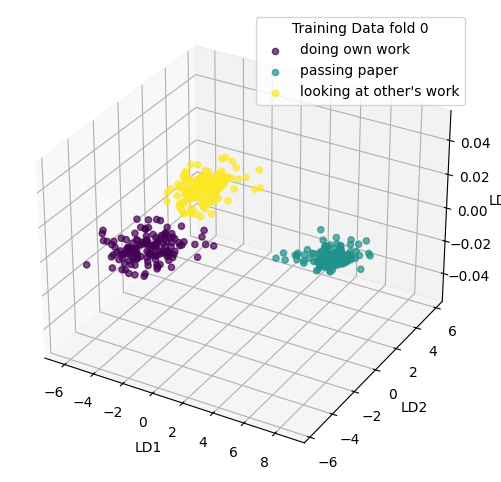

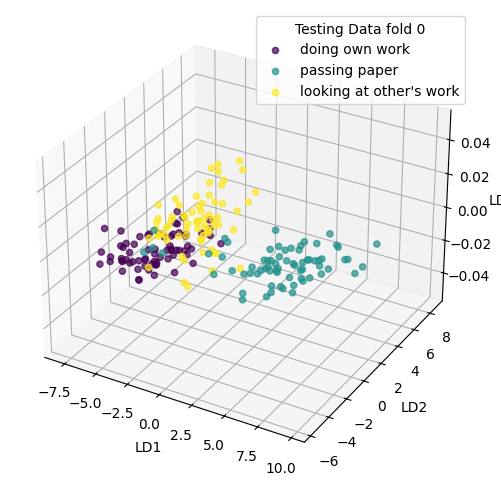

Fold accuracy: 80.48%


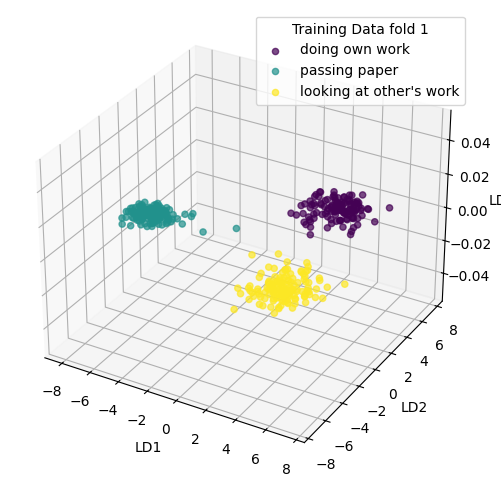

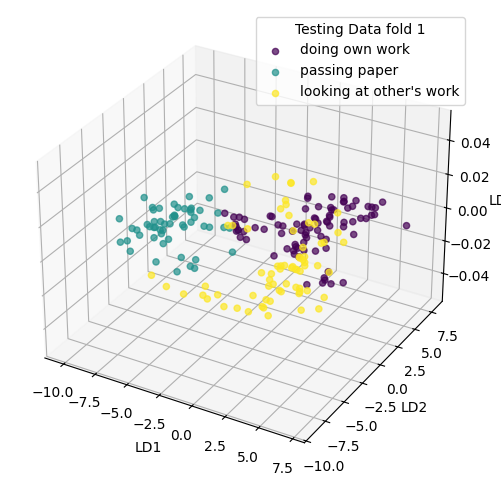

Fold accuracy: 74.76%


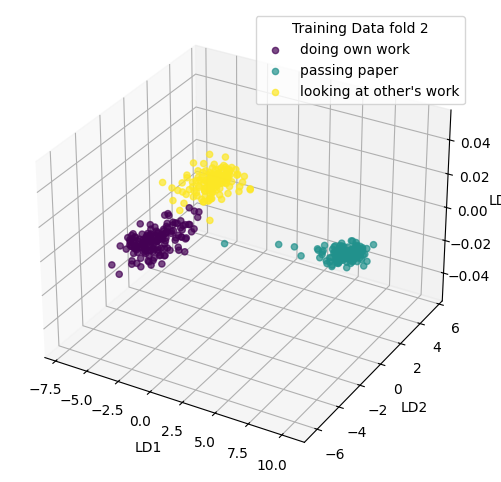

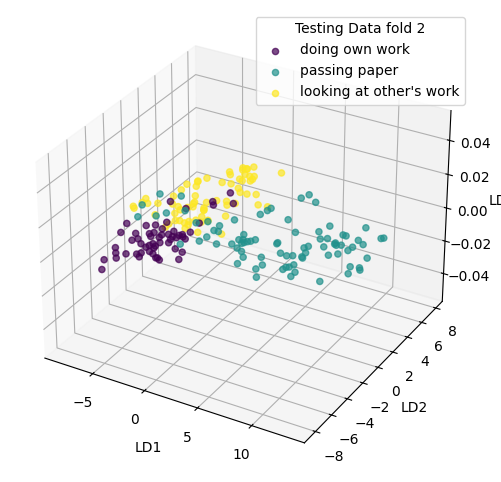

Fold accuracy: 84.29%


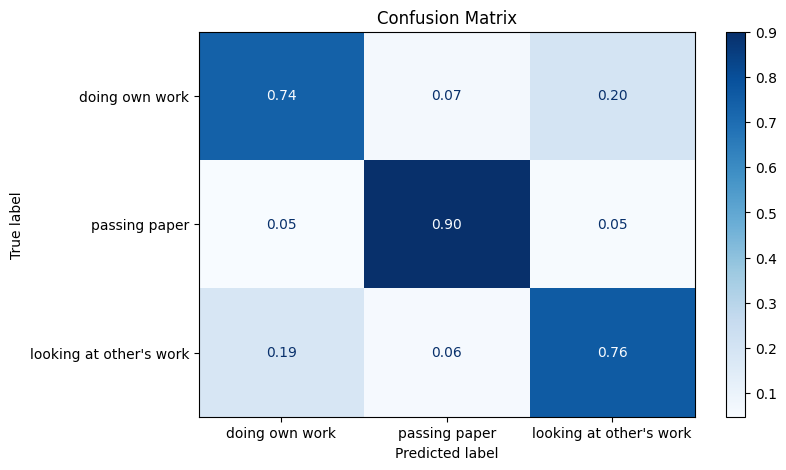

classes ['doing own work', 'passing paper', "looking at other's work"]
Precision for each class [0.76107231 0.88510101 0.75250752]
Recall for each class [0.75436508 0.91190476 0.75714286]
F1 score for each class [0.75405219 0.88929904 0.75416429]
Mean precision: 0.7996
Mean recall: 0.8078
Mean SVM accuracy: 79.84%
fl score: 0.7991718399421388


In [ ]:
# Machine learning classification pipeline code

def plot_class_separation_3d(X, Y, title):
    class_names = ['doing own work', 'passing paper', "looking at other's work"]
    num_classes = len(class_names)

    # Create a color map
    cmap = plt.get_cmap('viridis', num_classes)

    # Create a figure and a 3D axis
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each class with its own color
    for i in range(num_classes):
        indices = Y == i
        ax.scatter(X[indices, 0], X[indices, 1],
                   color=cmap(i), label=class_names[i], alpha=0.7)

    # Create a legend with class names
    ax.legend(title=title)
    ax.set_xlabel('LD1')
    ax.set_ylabel('LD2')
    ax.set_zlabel('LD3')

    plt.show()


def gridSearch(X, Y, group_ids):

    X, Y, group_ids = get_samples(X, Y, group_ids)
    X = X.reshape(X.shape[0], -1)

    # Define the parameter grid for SVM
    param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],                # Include default value 1.0
    'svm__gamma': [1e-3, 1e-4, 1e-5, 1e-1, 1e-2, 'scale', 'auto'], # Include default values 'scale' and 'auto'
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'] # Try different kernels
    }

    # Create a pipeline that includes scaling, LDA, and SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),        # Feature scaling
        ('lda', LDA(n_components=2)),        # Linear Discriminant Analysis
        ('svm', SVC(kernel="rbf"))           # SVM with RBF kernel
    ])

    # Use LeaveOneGroupOut cross-validation
    logo = LeaveOneGroupOut()

    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
        'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
        'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
    }

    # Set up GridSearchCV with the pipeline, parameter grid, and cross-validation scheme
    grid_search = GridSearchCV(pipeline, param_grid, cv=logo, scoring=scoring, refit=False)

    # Fit the grid search to the data
    grid_search.fit(X, Y, groups=group_ids)

    best_index = grid_search.cv_results_['rank_test_accuracy'].argmin()
    best_params = grid_search.cv_results_['params'][best_index]
    best_accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]

    # Get the best parameters
    print(f'Best parameters: {best_params}')

    # Get the best metrics
    print(f'Best accuracy: {best_accuracy:.4f}')

    return best_params

def classificationWithBestParam(X, Y, group_ids, best_params):

    X, Y, group_ids = get_samples(X, Y, group_ids)
    X = X.reshape(X.shape[0], -1)

    all_y_pred = []
    all_y_true = []

    scaler = MinMaxScaler()
    logo = LeaveOneGroupOut()
    lda = LDA(n_components=2)

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    save_dir = '/content/drive/MyDrive/FYP/ML_training_new'
    os.makedirs(save_dir, exist_ok=True)
    fold = 0

    for train_index, test_index in logo.split(X, Y, groups=group_ids):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        X_train_lda = lda.fit_transform(X_train, Y_train)
        X_test_lda = lda.transform(X_test)

        best_svm = SVC(kernel = best_params['svm__kernel'], C=best_params['svm__C'], gamma= best_params['svm__gamma'])
        best_svm.fit(X_train_lda, Y_train)

        plot_class_separation_3d(X_train_lda, Y_train, f'Training Data fold {fold}')
        plot_class_separation_3d(X_test_lda, Y_test, f'Testing Data fold {fold}')

        Y_pred = best_svm.predict(X_test_lda)
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred, average=None,zero_division=0)
        recall = recall_score(Y_test, Y_pred, average=None)
        f1 = f1_score(Y_test, Y_pred, average=None)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        all_y_pred.extend(Y_pred)
        all_y_true.extend(Y_test)
        print(f'Fold accuracy: {accuracy * 100:.2f}%')

         # Save trained models using joblib
        lda_model_path = os.path.join(save_dir, f"lda_fold_{fold}.joblib")
        svm_model_path = os.path.join(save_dir, f"svm_fold_{fold}.joblib")
        scalar_model_path = os.path.join(save_dir, f"scaler_fold_{fold}.joblib")

        joblib.dump(lda, lda_model_path)
        joblib.dump(best_svm, svm_model_path)
        joblib.dump(scaler, scalar_model_path)

        fold += 1


    # Compute and display confusion matrix
    cm = confusion_matrix(all_y_true, all_y_pred, labels=np.unique(Y))

    # Normalize the confusion matrix to show percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    class_names = ['doing own work', 'passing paper', "looking at other's work"]
    # Plot confusion matrix with accuracy percentages
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 5))

    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
    # Set aspect ratio to be equal
    ax.set_aspect('auto')
    plt.title("Confusion Matrix")
    plt.show()

    precisions = np.mean(precisions, axis=0)
    recalls = np.mean(recalls, axis=0)
    f1_scores = np.mean(f1_scores, axis=0)

    print("classes", class_names)
    print("Precision for each class", precisions)
    print("Recall for each class", recalls)
    print("F1 score for each class", f1_scores)
    print(f'Mean precision: {np.mean(precisions):.4f}')
    print(f'Mean recall: {np.mean(recalls):.4f}')
    print(f'Mean SVM accuracy: {np.mean(accuracies) * 100:.2f}%')
    print(f"fl score: {np.mean(f1_scores)}")


if __name__ == "__main__":
    # Assuming you have a method to get your data as a DataFrame
    video_df = get_ground_truth()

    X = []
    Y = []
    group_ids = []

    for video, video_row in video_df.iterrows():
        combined_features  = reading_features(video_row['hof_path'], video_row['dist_path'], video_row['angle_path'])
        X.append(combined_features)
        Y.append(video_row['action'])
        group_ids.append(video_row['fold'])

    X = np.array(X)
    Y = np.array(Y)

    best_param = gridSearch(X, Y, group_ids)
    classificationWithBestParam(X, Y, group_ids, best_param)

# Best parameters: {'svm__C': 0.01, 'svm__gamma': 0.1, 'svm__kernel': 'sigmoid'}
# Best accuracy: 0.7984

# Deep learning classification pipeline

### Summary
In this pipeline, five features (HOF, angle, distance, LTP and velocity) are used for classification using a Bi directional LSTM for classification. First, a grid search is done to find the best hyperparameters for Bi directional LSTM that give the best accuracy. Then, the classification is done again using the found best hyperparameters of BiLSTM to store the scalars and BiLSTM wieghts for each fold.

### Bi directional LSTM pytorch code
This is the Bi LSTM pytorch code. With setting bidirectional parameter to false, this code returns a LSTM instead.

In [ ]:

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional=False):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM Layer (Bi-directional if specified)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)

        # Output Layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # ReLU activation and Dropout for regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # LSTM Layer - Get output and hidden state (we don't need the hidden state here)
        lstm_out, _ = self.lstm(x)  # LSTM output shape: (batch_size, seq_len, hidden_dim * 2)

        # If bidirectional, we take the output of the last timestep for each direction
        if self.bidirectional:
            # We take the concatenation of the forward and backward hidden states at the last time step
            final_hidden_state = torch.cat((lstm_out[:, -1, :self.hidden_dim], lstm_out[:, 0, self.hidden_dim:]), dim=-1)
        else:
            # If not bidirectional, just take the last timestep output
            final_hidden_state = lstm_out[:, -1, :]

        # Apply Dropout, then fully connected layer
        output = self.fc(self.dropout(self.relu(final_hidden_state)))

        return output


## Classification with BiLSTM with best hyperparameters
Classification is done using the best found hyperparameters of BiLSTM using grid search (code below) to store the scalars, and BiLSTM weights for each fold and display the confusion matrix, accuracy, precision, recall and f1 score for all classes. The scalars and BiLSTM weights that gave the best fold accuracy will be used for inference.


num_features 571
Epoch 1: Validation Loss: 0.5133040717669896 (Model saved)
Epoch 2: Validation Loss: 0.2145568664584841 (Model saved)
Fold 0 accuracy: 94.29%
Epoch 1: Validation Loss: 0.5023981715951648 (Model saved)
Epoch 4: Validation Loss: 0.3559606386614697 (Model saved)
Fold 1 accuracy: 90.48%
Epoch 1: Validation Loss: 0.35473761494670597 (Model saved)
Epoch 11: Validation Loss: 0.23107284008126175 (Model saved)
Fold 2 accuracy: 92.38%


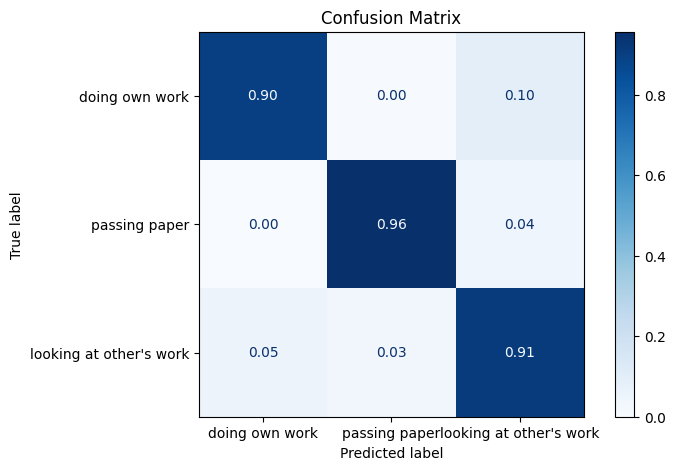

classes ['doing own work', 'passing paper', "looking at other's work"]
Precision for each class [0.94590643 0.96313353 0.87999103]
Recall for each class [0.91468254 0.96269841 0.91428571]
F1 score for each class [0.92401495 0.96264044 0.89176945]
Mean precision: 0.9297
Mean recall: 0.9306
fl score: 0.9261416097307968
Mean BiLSTM accuracy: 92.38%


In [ ]:

def classificationWithBiLSTM(X, Y, group_ids, hidden_dim, num_layers, lr, bidirectional, epochs=100):
    X, Y, group_ids = get_samples(X, Y, group_ids)
    num_videos, window_size, num_features = X.shape
    print("num_features", num_features)
    num_classes = len(np.unique(Y))

    all_y_true = []
    all_y_pred = []

    save_dir = '/content/drive/MyDrive/FYP/DL_training'
    os.makedirs(save_dir, exist_ok=True)

    SCALERS = {
      "dist": MinMaxScaler(),
      "angle": MinMaxScaler(),
      "hof": StandardScaler(),
      "vel": RobustScaler(),
      "ltp": MinMaxScaler()
    }

    selected_features_len = {
      "dist": 12,
      "angle": 15,
      "hof": 18,
      "vel": 14,
      "ltp": 512
    }

    selected_features = ["hof", "dist", "angle", "ltp", "vel"]
    logo = LeaveOneGroupOut()
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    fold = 0

    for train_idx, test_idx in logo.split(X, Y, groups=group_ids):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        prev_feat_length = 0
        standard_X_train, standard_X_test = None, None

        for feature in selected_features:
            X_train_subset = X_train[:, :, prev_feat_length:prev_feat_length + selected_features_len[feature]].reshape(X_train.shape[0], -1)
            X_test_subset = X_test[:, :, prev_feat_length:prev_feat_length + selected_features_len[feature]].reshape(X_test.shape[0], -1)

            scaler = SCALERS[feature]
            X_train_subset = scaler.fit_transform(X_train_subset)
            X_test_subset = scaler.transform(X_test_subset)

            scalar_model_path = os.path.join(save_dir, f"scaler_{feature}_fold_{len(accuracies)}.joblib")
            joblib.dump(scaler, scalar_model_path)

            X_train_subset = X_train_subset.reshape(X_train.shape[0], window_size, -1)
            X_test_subset = X_test_subset.reshape(X_test.shape[0], window_size, -1)

            if standard_X_train is None:
                standard_X_train = X_train_subset
                standard_X_test = X_test_subset
            else:
                standard_X_train = np.concatenate((standard_X_train, X_train_subset), axis=2)
                standard_X_test = np.concatenate((standard_X_test, X_test_subset), axis=2)

            prev_feat_length += selected_features_len[feature]

        X_train = standard_X_train
        X_test = standard_X_test

        # Convert data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)

        train_data = Data.TensorDataset(X_train_tensor, Y_train_tensor)
        test_data = Data.TensorDataset(X_test_tensor, Y_test_tensor)

        train_loader = Data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
        test_loader = Data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)

        best_accuracy = 0.0  # Track best accuracy
        best_model_path = f"{save_dir}/best_model_fold_{len(accuracies)}.pth"  # Unique model filename for each fold

        model = BiLSTM(num_features, hidden_dim, num_classes, num_layers, bidirectional).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Learning Rate Scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

        # Training loop
        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Validation (after each epoch)
            model.eval()
            y_pred_fold, y_true_fold = [], []
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)

                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    y_pred_fold.extend(preds.cpu().numpy())
                    y_true_fold.extend(labels.cpu().numpy())
            val_loss /= len(test_loader)

            # Compute validation accuracy
            accuracy = accuracy_score(y_true_fold, y_pred_fold)

            if accuracy > best_accuracy:  # Save model if accuracy improves
                best_accuracy = accuracy
                torch.save(model.state_dict(), best_model_path)
                print(f"Epoch {epoch+1}: Validation Loss: {val_loss} (Model saved)")

            scheduler.step(val_loss)  # Update learning rate

        # Testing
        model.load_state_dict(torch.load(best_model_path, weights_only=True))
        model.eval()

        y_pred_fold, y_true_fold = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_pred_fold.extend(preds.detach().cpu().numpy())  # Ensure moving tensors to CPU before converting to numpy
                y_true_fold.extend(labels.detach().cpu().numpy())

        # Metrics
        accuracy = accuracy_score(y_true_fold, y_pred_fold)
        precision = precision_score(y_true_fold, y_pred_fold, average=None, zero_division=0)
        recall = recall_score(y_true_fold, y_pred_fold, average=None, zero_division=0)
        f1 = f1_score(y_true_fold, y_pred_fold, average=None, zero_division=0)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        all_y_pred.extend(y_pred_fold)
        all_y_true.extend(y_true_fold)

        print(f'Fold {fold} accuracy: {accuracy * 100:.2f}%')
        fold += 1


    # Confusion matrix visualization
    cm = confusion_matrix(all_y_true, all_y_pred, labels=np.unique(Y))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_names = ['doing own work', 'passing paper', "looking at other's work"]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
    plt.title("Confusion Matrix")
    plt.show()

    precisions = np.mean(precisions, axis=0)
    recalls = np.mean(recalls, axis=0)
    f1_scores = np.mean(f1_scores, axis=0)

    print("classes", class_names)
    print("Precision for each class", precisions)
    print("Recall for each class", recalls)
    print("F1 score for each class", f1_scores)
    print(f'Mean precision: {np.mean(precisions):.4f}')
    print(f'Mean recall: {np.mean(recalls):.4f}')
    print(f"fl score: {np.mean(f1_scores)}")
    print(f'Mean BiLSTM accuracy: {np.mean(accuracies) * 100:.2f}%')


if __name__ == "__main__":
    video_df = get_ground_truth()

    X = []
    Y = []
    group_ids = []

    for video, video_row in video_df.iterrows():
        combined_feat  = reading_features(video_row['hof_path'], video_row['dist_path'], video_row['angle_path'],
                      video_row['ltp_path'], video_row['vel_path'])

        X.append(combined_feat)
        Y.append(video_row['action'])
        group_ids.append(video_row['fold'])

    X = np.array(X)
    Y = np.array(Y)

    classificationWithBiLSTM(X, Y, group_ids, 128, 2, 0.001, True)


# {'hidden_dim': 128, 'num_layers': 2, 'lr': 0.001, 'bidirectional': True}
# Best Accuracy: 92.38%


## Grid search for hyperparameter tuning of BiLSTM
This code does a hyperparameters grid search on no of hidden units, no of layers and learning rate for finding best BiLSTM weights for classification.
We also did grid search on simple LSTM and found that it gave less accuracy than BiLSTM for majority of hyperparameters. This is the reason BiLSTM was choosen for classification of our deep learning pipeline.



In [ ]:

def gridSearchWithBiLSTM(X, Y, group_ids, hidden_dims=[128, 256], num_layers_list=[1, 2], lrs=[1e-3, 1e-4], bidirectional_list=[False, True], epochs=100):
    X, Y, group_ids = get_samples(X, Y, group_ids)
    num_videos, window_size, num_features = X.shape
    num_classes = len(np.unique(Y))

    overall_best_accuracy = 0
    best_params = {}

    SCALERS = {
      "dist": MinMaxScaler(),
      "angle": MinMaxScaler(),
      "hof": StandardScaler(),
      "vel": RobustScaler(),
      "ltp": MinMaxScaler(),
    }

    selected_features_len = {
      "dist": 12,
      "angle": 15,
      "hof": 18,
      "vel": 14,
      "ltp": 512
    }

    selected_features = ["hof", "dist", "angle", "ltp", "vel"]

    # Loop over all combinations of parameters
    for hidden_dim in hidden_dims:
        for num_layers in num_layers_list:
            for lr in lrs:
                for bidirectional in bidirectional_list:
                    print(f"Training with hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr} bidirectional {bidirectional}")

                    logo = LeaveOneGroupOut()
                    accuracies = []
                    fold = 0

                    for train_idx, test_idx in logo.split(X, Y, groups=group_ids):

                        X_train, X_test = X[train_idx], X[test_idx]
                        Y_train, Y_test = Y[train_idx], Y[test_idx]

                        prev_feat_length = 0
                        standard_X_train, standard_X_test = None, None

                        for feature in selected_features:
                            X_train_subset = X_train[:, :, prev_feat_length:prev_feat_length + selected_features_len[feature]].reshape(X_train.shape[0], -1)
                            X_test_subset = X_test[:, :, prev_feat_length:prev_feat_length + selected_features_len[feature]].reshape(X_test.shape[0], -1)

                            scaler = SCALERS[feature]
                            X_train_subset = scaler.fit_transform(X_train_subset)
                            X_test_subset = scaler.transform(X_test_subset)

                            X_train_subset = X_train_subset.reshape(X_train.shape[0], window_size, -1)
                            X_test_subset = X_test_subset.reshape(X_test.shape[0], window_size, -1)

                            if standard_X_train is None:
                                standard_X_train = X_train_subset
                                standard_X_test = X_test_subset
                            else:
                                standard_X_train = np.concatenate((standard_X_train, X_train_subset), axis=2)
                                standard_X_test = np.concatenate((standard_X_test, X_test_subset), axis=2)

                            prev_feat_length += selected_features_len[feature]

                        X_train = standard_X_train
                        X_test = standard_X_test

                        # Convert data to PyTorch tensors
                        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
                        Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
                        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
                        Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)

                        train_data = Data.TensorDataset(X_train_tensor, Y_train_tensor)
                        test_data = Data.TensorDataset(X_test_tensor, Y_test_tensor)

                        train_loader = Data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
                        test_loader = Data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)

                        model = BiLSTM(num_features, hidden_dim, num_classes, num_layers, bidirectional).to(device)

                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.Adam(model.parameters(), lr=lr)

                        # Learning Rate Scheduler
                        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
                        best_accuracy = 0.0  # Track best accuracy

                        # Training loop
                        for epoch in range(epochs):
                            model.train()
                            for inputs, labels in train_loader:
                                optimizer.zero_grad()
                                inputs = inputs.to(device)
                                labels = labels.to(device)
                                outputs = model(inputs)

                                loss = criterion(outputs, labels)
                                loss.backward()
                                optimizer.step()

                            # Validation (after each epoch)
                            model.eval()
                            y_pred_fold, y_true_fold = [], []
                            val_loss = 0.0
                            with torch.no_grad():
                                for inputs, labels in test_loader:
                                    inputs = inputs.to(device)
                                    labels = labels.to(device)
                                    outputs = model(inputs)

                                    loss = criterion(outputs, labels)
                                    val_loss += loss.item()

                                    _, preds = torch.max(outputs, 1)
                                    y_pred_fold.extend(preds.cpu().numpy())
                                    y_true_fold.extend(labels.cpu().numpy())
                            val_loss /= len(test_loader)

                            # Compute validation accuracy
                            accuracy = accuracy_score(y_true_fold, y_pred_fold)

                            if accuracy > best_accuracy:  # Save model if accuracy improves
                                best_accuracy = accuracy

                            scheduler.step(val_loss)  # Update learning rate

                        print(f"fold {fold} accuracy {best_accuracy}")

                        fold += 1
                        accuracies.append(best_accuracy)

                    mean_accuracy = np.mean(accuracies)

                    print("mean accuracy", mean_accuracy)

                    # Update best parameters if current combination is better
                    if mean_accuracy > overall_best_accuracy:
                        overall_best_accuracy = mean_accuracy
                        best_params = {
                            "hidden_dim": hidden_dim,
                            "num_layers": num_layers,
                            "lr": lr,
                            "bidirectional": bidirectional
                        }

    # Output the best parameters
    print("Best Parameters:")
    print(best_params)
    print(f"Best Accuracy: {overall_best_accuracy * 100:.2f}%")


if __name__ == "__main__":
    video_df = get_ground_truth()

    X = []
    Y = []
    group_ids = []

    for video, video_row in video_df.iterrows():
        combined_feat  = reading_features(video_row['hof_path'], video_row['dist_path'], video_row['angle_path'],
                      video_row['ltp_path'], video_row['vel_path'])

        X.append(combined_feat)
        Y.append(video_row['action'])
        group_ids.append(video_row['fold'])

    X = np.array(X)
    Y = np.array(Y)

    gridSearchWithBiLSTM(X, Y, group_ids)



Training with hidden_dim=128, num_layers=1, lr=0.001 bidirectional False
fold 0 accuracy 0.9
fold 1 accuracy 0.9142857142857143
fold 2 accuracy 0.8904761904761904
mean accuracy 0.9015873015873016
Training with hidden_dim=128, num_layers=1, lr=0.001 bidirectional True
fold 0 accuracy 0.9238095238095239
fold 1 accuracy 0.8571428571428571
fold 2 accuracy 0.9523809523809523
mean accuracy 0.9111111111111111
Training with hidden_dim=128, num_layers=1, lr=0.0001 bidirectional False
fold 0 accuracy 0.8761904761904762
fold 1 accuracy 0.8666666666666667
fold 2 accuracy 0.9238095238095239
mean accuracy 0.888888888888889
Training with hidden_dim=128, num_layers=1, lr=0.0001 bidirectional True
fold 0 accuracy 0.9047619047619048
fold 1 accuracy 0.8952380952380953
fold 2 accuracy 0.9285714285714286
mean accuracy 0.9095238095238095
Training with hidden_dim=128, num_layers=2, lr=0.001 bidirectional False
fold 0 accuracy 0.9285714285714286
fold 1 accuracy 0.9095238095238095
fold 2 accuracy 0.90952380952

# Visualization codes
## Dataset visualization code
This code displays some frames from the dataset used in our work.

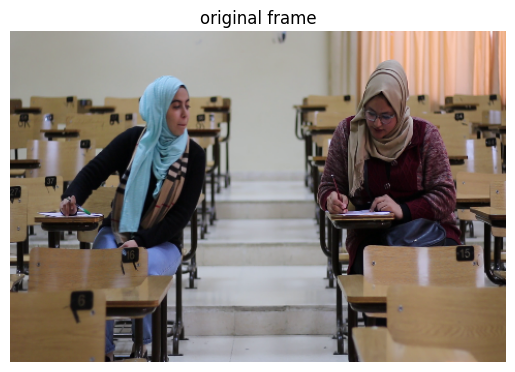

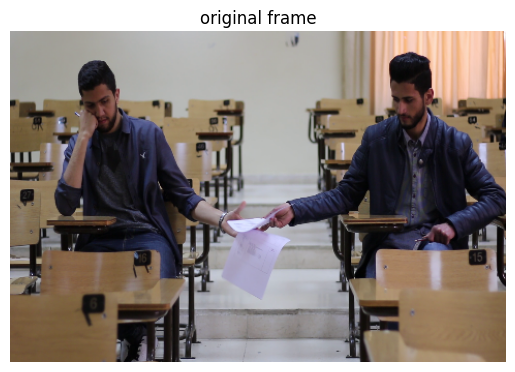

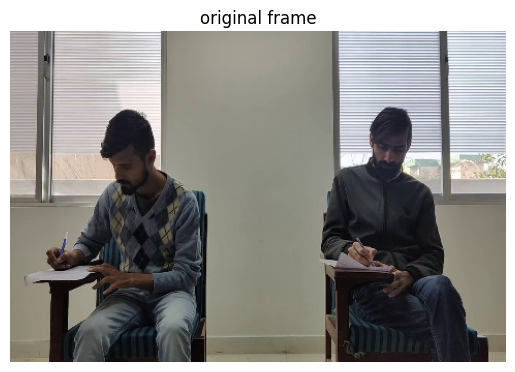

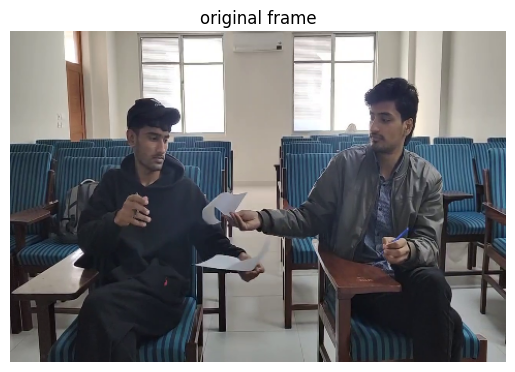

In [ ]:


def visualize_dataset(video_path, silhouette_path):

    cap = cv2.VideoCapture(video_path)
    silhouette_name = os.path.basename(silhouette_path)
    frame_no = int(os.path.splitext(silhouette_name)[0])

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)

    # Read the frame from the video
    ret, frame = cap.read()

    if not ret:
      raise ValueError(f"Failed to read frame {frame_no} from the video!")

    new_width = 480
    new_height = 320
    resized_frame = cv2.resize(frame, (new_width, new_height))

    cap.release()

    plt.imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))
    plt.title("original frame")
    plt.axis('off')
    plt.show()


if __name__ == "__main__":

    videos = []
    silhouettes = []

    # looking at other's work
    videos.append("/content/drive/MyDrive/FYP/Dataset/7_3.MOV")
    silhouettes.append("/content/drive/MyDrive/FYP/Silhouetes/7_3/80.png")

    # passing paper
    videos.append("/content/drive/MyDrive/FYP/Dataset/1_2.MOV")
    silhouettes.append("/content/drive/MyDrive/FYP/Silhouetes/1_2/70.png")

    # doing own work
    videos.append("/content/drive/MyDrive/FYP/Dataset/79_1.mp4")
    silhouettes.append("/content/drive/MyDrive/FYP/Silhouetes/79_1/59.png")

    # passing paper
    videos.append("/content/drive/MyDrive/FYP/Dataset/18_2.mp4")
    silhouettes.append("/content/drive/MyDrive/FYP/Silhouetes/18_2/48.png")

    for video_path, silhouette_path in zip(videos, silhouettes):
        visualize_dataset(video_path, silhouette_path)


## Silhouettes visualization code
This code displays some frames and their corresponding gray scale silhouettes extracted using MASK R-CNN.

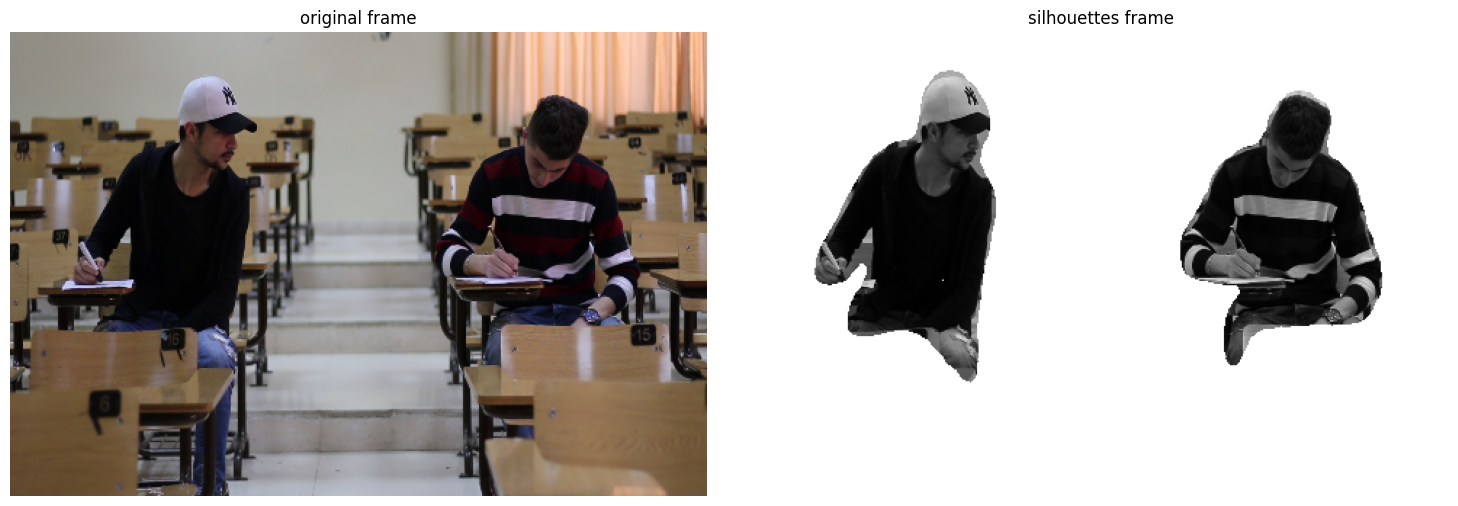

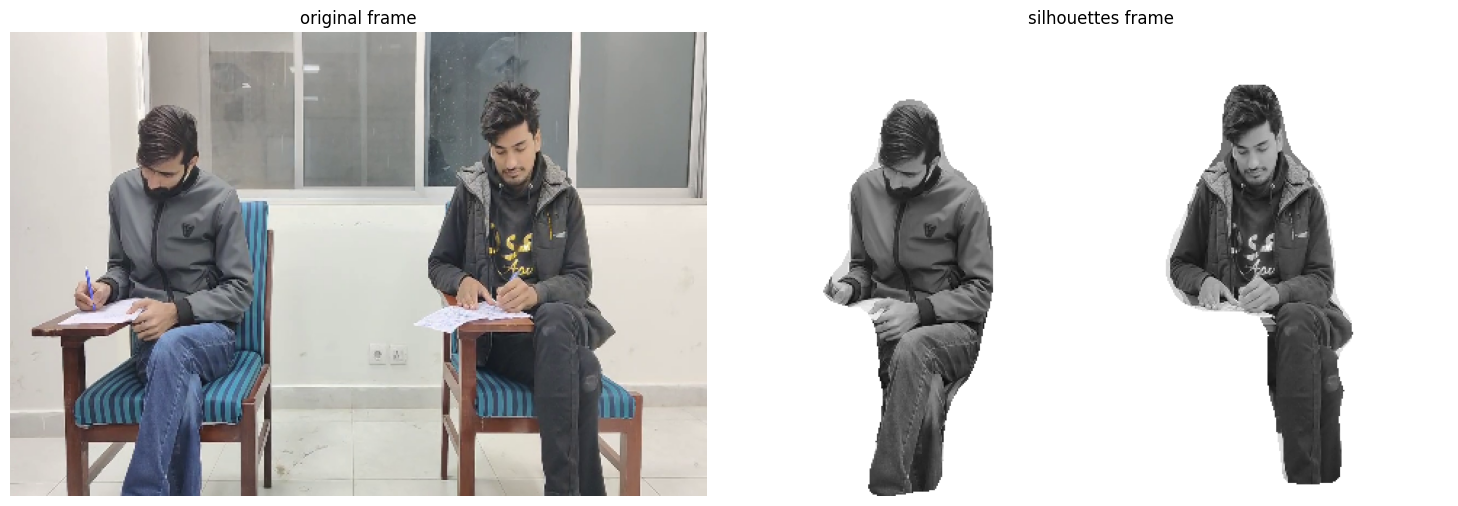

In [ ]:


def visualize_silhouettes(video_path, silhouette_path):

    cap = cv2.VideoCapture(video_path)
    silhouette_name = os.path.basename(silhouette_path)
    frame_no = int(os.path.splitext(silhouette_name)[0])

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)

    # Read the frame from the video
    ret, frame = cap.read()

    if not ret:
      raise ValueError(f"Failed to read frame {frame_no} from the video!")

    new_width = 480
    new_height = 320
    resized_frame = cv2.resize(frame, (new_width, new_height))

    cap.release()

    silhouette = cv2.imread(silhouette_path, cv2.IMREAD_GRAYSCALE)
    silhouette[silhouette == 0] = 255
    # silhouette = cv2.resize(silhouette, (640, 480))

    plt.figure(figsize=(15, 5))

    # Plot the curr sihouette
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))
    plt.title("original frame")
    plt.axis('off')

    # Plot silhouette
    plt.subplot(1, 2, 2)
    plt.imshow(silhouette, cmap="gray")
    plt.title("silhouettes frame")
    plt.axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    videos = []
    silhouettes = []

    # looking at other's work
    videos.append("/content/drive/MyDrive/FYP/Dataset/11_3.MOV")
    silhouettes.append("/content/drive/MyDrive/FYP/Silhouetes/11_3/100.png")

    # doing own work
    videos.append("/content/drive/MyDrive/FYP/Dataset/52_1.mp4")
    silhouettes.append("/content/drive/MyDrive/FYP/Silhouetes/52_1/80.png")

    for video_path, silhouette_path in zip(videos, silhouettes):
        visualize_silhouettes(video_path, silhouette_path)


## Keypoints visualization code
This code displays some frames and keypoints of individuals along with their bounding boxes and track ids detected by YOLO11n Pose.

shape (2, 17, 3)
track_ids no 2


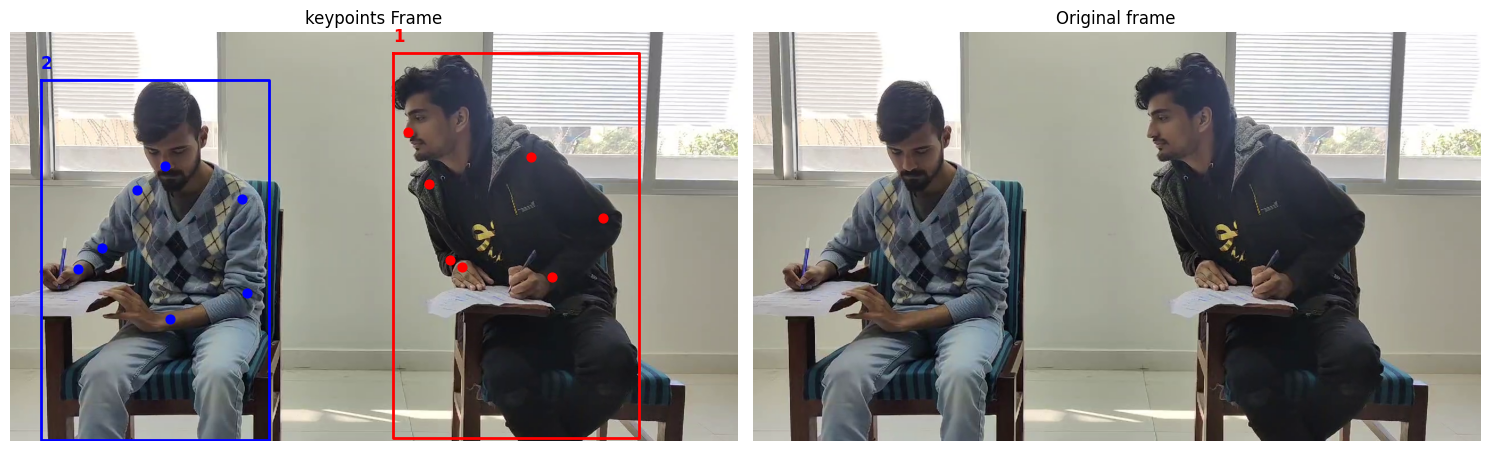

shape (2, 17, 3)
track_ids no 2


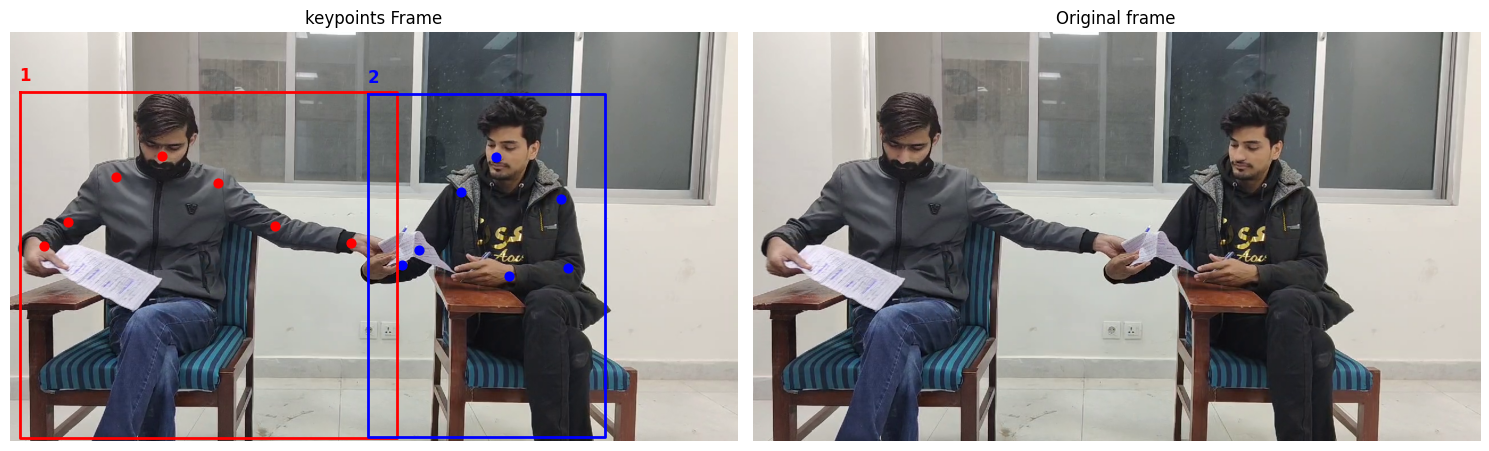

In [ ]:

# specific indexes of keypoints to retain
SPECIFIC_INDEXES = [0, 5, 6, 7, 8, 9, 10]
# 7 keypoints per person
NUM_KEYPOINTS = len(SPECIFIC_INDEXES)
COLORS = {1: 'red', 2: 'blue', 3: 'yellow', 4: 'green'}

def plot_keypoints(frame, frame_keypoints, track_ids, boxes):

    plt.figure(figsize=(15, 5))

     # Plot the original frame
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("keypoints Frame")
    plt.axis('off')

     # Process keypoints for both persons
    for person_data, track_id in zip(frame_keypoints, track_ids):  # Ensure only 2 persons
        for k, index in enumerate(SPECIFIC_INDEXES):
            plt.scatter(person_data[index][:2][0], person_data[index][:2][1], color=COLORS.get(track_id, 'pink'), s=40)

    for box, track_id in zip(boxes, track_ids):
        x_min, y_min, x_max, y_max = box
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color= COLORS.get(track_id, 'green'), linewidth=2)
        # Visualize track ID
        plt.text(x_min, y_min - 20, f"{track_id}", color=COLORS.get(track_id, 'green'), fontsize=12, weight="bold")

    # Plot the frame with keypoints and bounding box
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Original frame")
    plt.axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()


def keypoints_visualization(video_path, silhouette_path):
    """Extract keypoints from the middle 50 frames using batch processing for speed."""
    device = '0' if torch.cuda.is_available() else 'cpu'
    # Load YOLO model
    model = YOLO("/content/yolo11n-pose.pt")

    cap = cv2.VideoCapture(video_path)
    silhouette_name = os.path.basename(silhouette_path)
    frame_no = int(os.path.splitext(silhouette_name)[0])

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)

    # Read the frame from the video
    ret, frame = cap.read()

    if not ret:
      raise ValueError(f"Failed to read frame {frame_no} from the video!")

    # Run YOLO inference on batch
    results = model.track(frame, persist=True, max_det=2, classes=[0], verbose=False, device=device, tracker="bytetrack.yaml", iou=0.95,
                              conf=0.1)
    results = results[:1]

    for i, result in enumerate(results):
        # Extract keypoints and track IDs
        frame_keypoints = result.keypoints.data.cpu().numpy() if result.keypoints is not None else []
        track_ids = result.boxes.id.int().cpu().tolist() if result.boxes.id is not None else []
        boxes = result.boxes.xyxy.cpu().numpy() if result.boxes.xyxy is not None else []

        plot_keypoints(frame, frame_keypoints, track_ids, boxes)

if __name__ == "__main__":
      keypoints = []
      frames = []
      videos = []
      silhouettes = []

       # looking at other's work
      videos.append("/content/drive/MyDrive/FYP/Dataset/75_3.mp4")
      silhouettes.append("/content/drive/MyDrive/FYP/Silhouetes/75_3/8.png")

      # passing paper
      videos.append("/content/drive/MyDrive/FYP/Dataset/51_2.mp4")
      silhouettes.append("/content/drive/MyDrive/FYP/Silhouetes/51_2/80.png")

      for frame_path, silhouette_path in zip(videos, silhouettes):
          keypoints_visualization(frame_path, silhouette_path)


## LTP features visualization code
This code displays LTP features extracted from gray scale silhouettes.

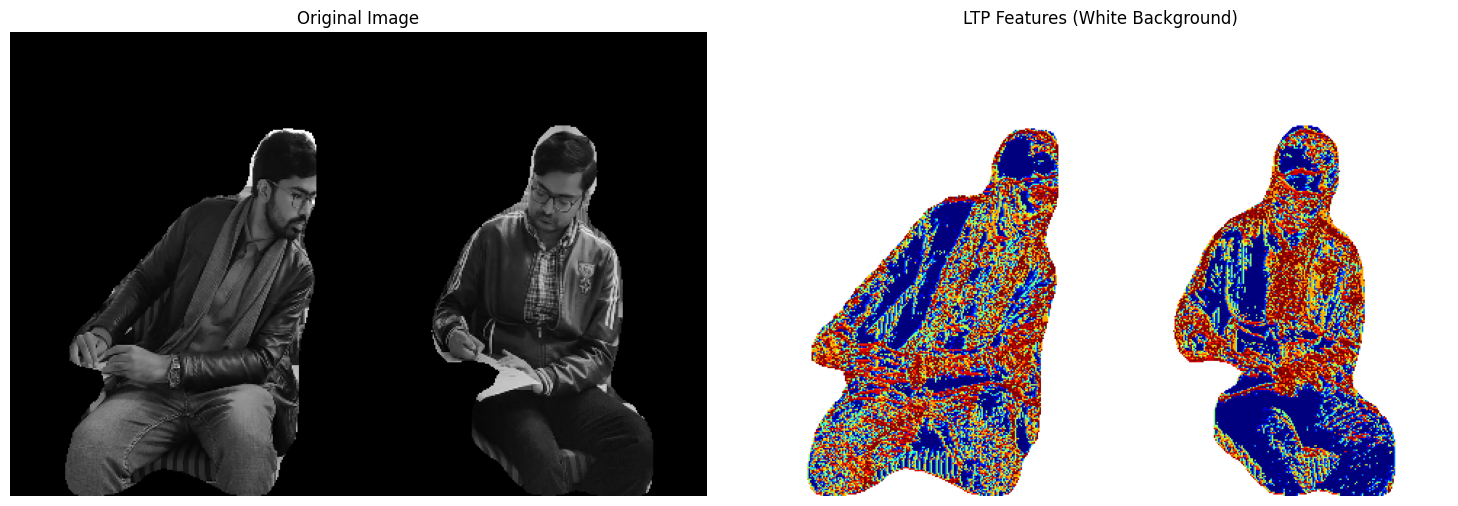

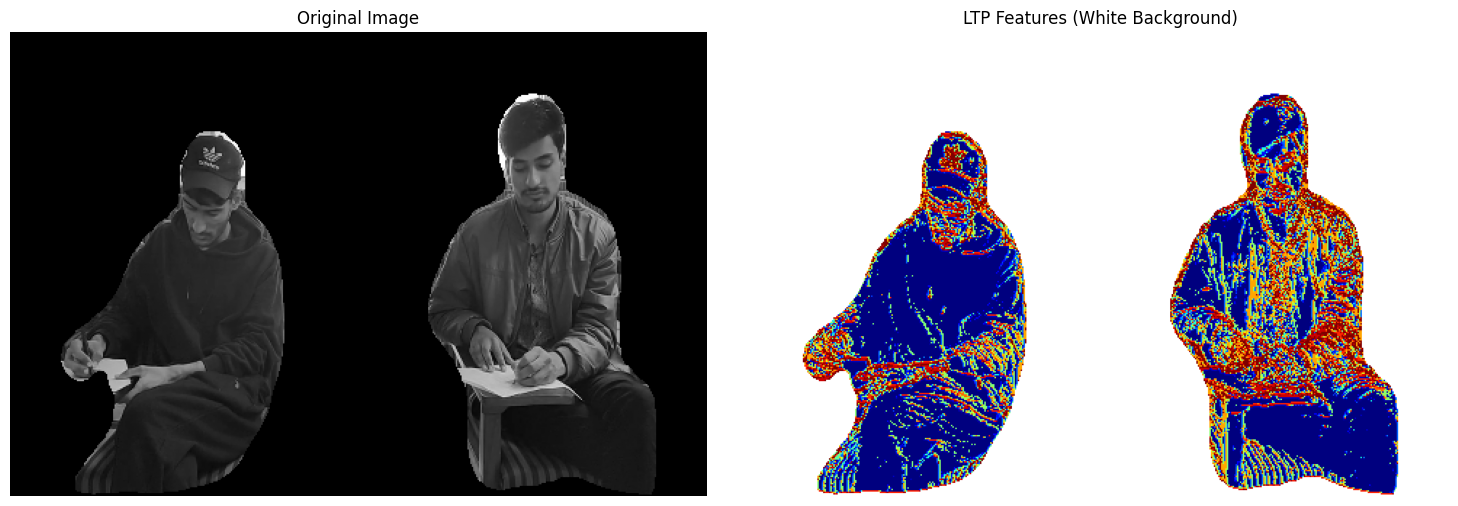

In [ ]:

def compute_ltp(image, radius=1, neighbors=8, threshold=5):
    """
    Compute Local Ternary Patterns (LTP) for a grayscale image efficiently.
    Uses NumPy vectorized operations and SciPy shift to improve speed.
    """
    image = image.astype(np.float32)
    padded_image = cv2.copyMakeBorder(image, radius, radius, radius, radius, cv2.BORDER_REFLECT)

    h, w = image.shape
    ltp_pos = np.zeros((h, w), dtype=np.uint8)
    ltp_neg = np.zeros((h, w), dtype=np.uint8)

    offsets = [
        (int(np.round(radius * np.sin(2 * np.pi * n / neighbors))),
         int(np.round(radius * np.cos(2 * np.pi * n / neighbors))))
        for n in range(neighbors)
    ]

    # Create stacked neighbor shifts
    neighbors_matrix = np.stack([
        shift(padded_image, shift=(dy, dx), mode='nearest')[radius:-radius, radius:-radius]
        for dy, dx in offsets
    ], axis=-1)  # Shape: (h, w, neighbors)

    center_matrix = image[..., None]  # Shape: (h, w, 1)
    diff = neighbors_matrix - center_matrix  # Compute differences

    # Compute LTP codes using NumPy boolean indexing (Vectorized)
    ltp_pos = np.sum((diff > threshold) * (1 << np.arange(neighbors)), axis=-1, dtype=np.uint8)
    ltp_neg = np.sum((diff < -threshold) * (1 << np.arange(neighbors)), axis=-1, dtype=np.uint8)

    return ltp_pos, ltp_neg


def visualize_ltp_features(image_path, radius=1, neighbors=8, threshold=5):
    """
    Visualize LTP features on a grayscale silhouette image using Matplotlib.

    Args:
        image (numpy.ndarray): Input grayscale image (silhouette).
        radius (int): Radius for LTP computation.
        neighbors (int): Number of neighbors for LTP computation.
        threshold (int): Threshold for LTP computation.

    Returns:
        None (displays the visualization using Matplotlib).
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

     # Create binary mask
    _, binary_mask = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
    # Compute LTP features
    ltp_pos, ltp_neg = compute_ltp(image, radius, neighbors, threshold)

    combined_ltp = ltp_pos + ltp_neg

    # Normalize LTP codes for visualization
    combined_ltp_norm = cv2.normalize(combined_ltp, None, 0, 255, cv2.NORM_MINMAX)

     # Apply jet colormap
    jet_colormap = plt.get_cmap('jet')
    colored_ltp = jet_colormap(combined_ltp_norm)[:, :, :3]  # Convert to RGB (0-1 float)

    # Create white background image
    white_bg = np.ones_like(colored_ltp)

    # Convert binary mask to 3-channel and boolean
    mask_3d = binary_mask[:, :, np.newaxis] > 0

    # Blend: where mask is True use colored_ltp, else use white
    final_image = np.where(mask_3d, colored_ltp, white_bg)
    # Create a figure to display the results
    plt.figure(figsize=(15, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # LTP visualization with white background
    plt.subplot(1, 2, 2)
    plt.imshow(final_image)
    plt.title("LTP Features (White Background)")
    plt.axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    # Load a grayscale silhouette image
    images_paths = []

    # looking at other's work
    images_paths.append("/content/drive/MyDrive/FYP/Silhouetes/41_3/85.png")
    # passing paper
    images_paths.append("/content/drive/MyDrive/FYP/Silhouetes/17_1/69.png")

    for image_path in images_paths:
      # Visualize LTP features
      visualize_ltp_features(image_path, radius=1, neighbors=8, threshold=5)

## HOF features visualization code
This code displays HOF features extracted from gray scale silhouettes.

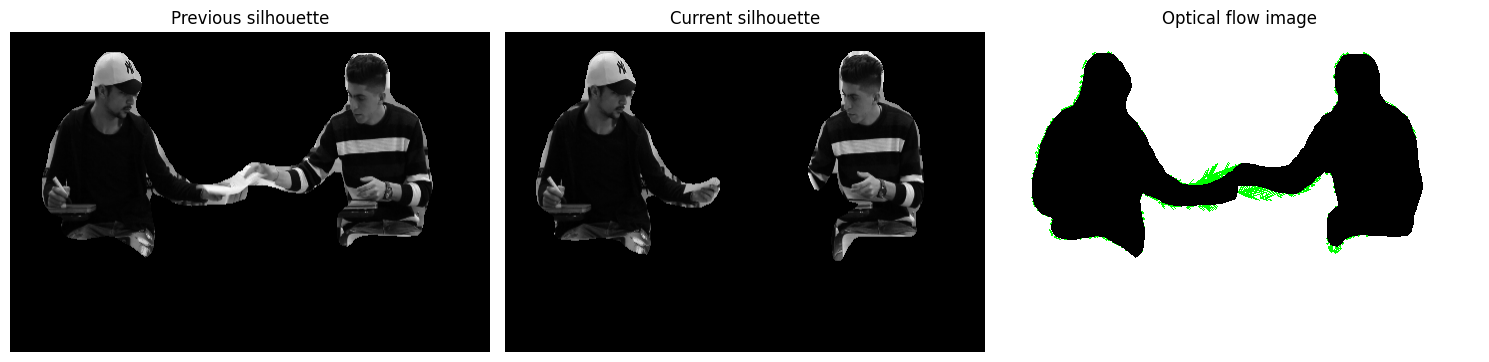

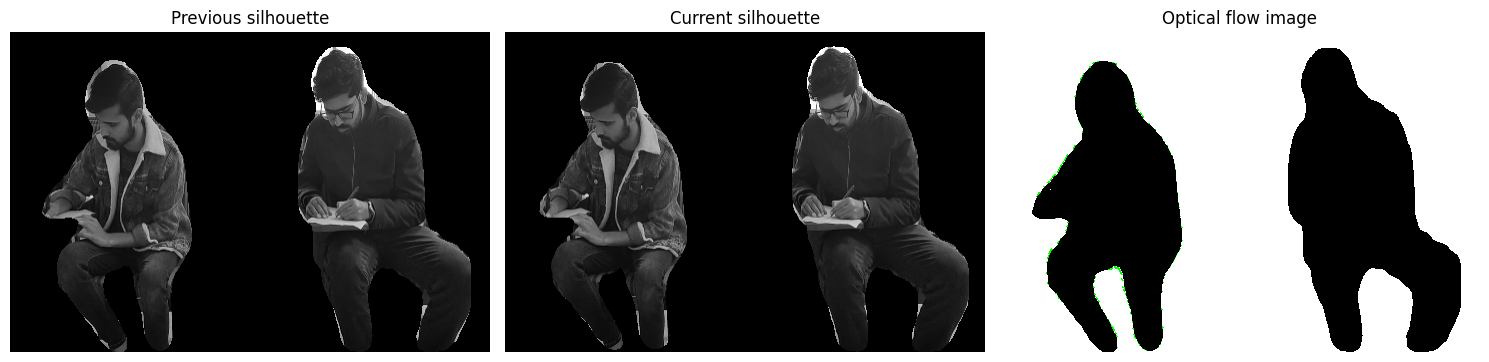

In [ ]:

def get_silhouette_contours(silhouette):
    # Find contours in the silhouette image
    contours, _ = cv2.findContours(silhouette, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours[0] if contours else np.array([])

def draw_optical_flow_on_contours(prev_frame, curr_frame, contours, step=16):

    flow = cv2.calcOpticalFlowFarneback(prev_frame, curr_frame, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2,
                                        flags=0)

    vis = np.zeros_like(prev_frame) # black background

    # Convert to BGR for drawing arrows
    vis_bgr = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

    # Draw optical flow vectors on contour points
    for contour_point in contours:  # Use every `step`-th point on the contour
        x, y = contour_point[0]
        flow_vector = flow[y, x]
        end_point = (int(x + flow_vector[0]), int(y + flow_vector[1]))

        cv2.arrowedLine(vis_bgr, (x, y), end_point, (0, 255, 0), 1, tipLength=0.4)

    # Convert silhouette to BGR
    silhouette_bgr = cv2.cvtColor(prev_frame, cv2.COLOR_GRAY2BGR)


    # Blend the silhouette with the black background and arrows
    vis_bgr[prev_frame > 0] = 255

    return vis_bgr

def visualize_optical_flow_on_silhouette(prev_frame_path, curr_frame_path, output_path=None):

    prev_frame = cv2.imread(prev_frame_path, cv2.IMREAD_GRAYSCALE)
    curr_frame = cv2.imread(curr_frame_path, cv2.IMREAD_GRAYSCALE)
    contours = get_silhouette_contours(prev_frame)

    if contours.size == 0:
        print("No contours found in the silhouette.")
        return

    flow_image = draw_optical_flow_on_contours(prev_frame, curr_frame, contours)

    flow_image = 255 - flow_image

    pink = np.array([255, 0, 255])  # Pure pink (R=255, G=0, B=255)
    green = np.array([0, 255, 0])   # Pure green (R=0, G=255, B=0)

    # Create a mask for all pink pixels (exact match)
    pink_mask = (flow_image == pink).all(axis=-1)

    # Replace pink with green
    flow_image[pink_mask] = green
     # Create a figure to display the results
    plt.figure(figsize=(15, 5))

    # Plot the previous silhouette
    plt.subplot(1, 3, 1)
    plt.imshow(prev_frame, cmap='gray')
    plt.title("Previous silhouette")
    plt.axis('off')

    # Plot the curr sihouette
    plt.subplot(1, 3, 2)
    plt.imshow(curr_frame, cmap='gray')
    plt.title("Current silhouette")
    plt.axis('off')

    # Plot optical flow features
    plt.subplot(1, 3, 3)
    plt.imshow(flow_image)  # Use 'jet' colormap for better visualization
    plt.title("Optical flow image")
    plt.axis('off')


    # Display the figure
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    curr_silhouettes_paths = []
    prev_silhouettes_paths = []

    # passing paper
    curr_silhouettes_paths.append("/content/drive/MyDrive/FYP/Silhouetes/4_2/112.png")
    prev_silhouettes_paths.append("/content/drive/MyDrive/FYP/Silhouetes/4_2/120.png")

    # doing own work
    curr_silhouettes_paths.append("/content/drive/MyDrive/FYP/Silhouetes/29_1/51.png")
    prev_silhouettes_paths.append("/content/drive/MyDrive/FYP/Silhouetes/29_1/60.png")


    for prev_silhouette_path, curr_silhouette_path in zip(prev_silhouettes_paths, curr_silhouettes_paths):
      visualize_optical_flow_on_silhouette(prev_silhouette_path, curr_silhouette_path)


## Velocity features visualization code
This code displays velocity features extracted from keypoints.

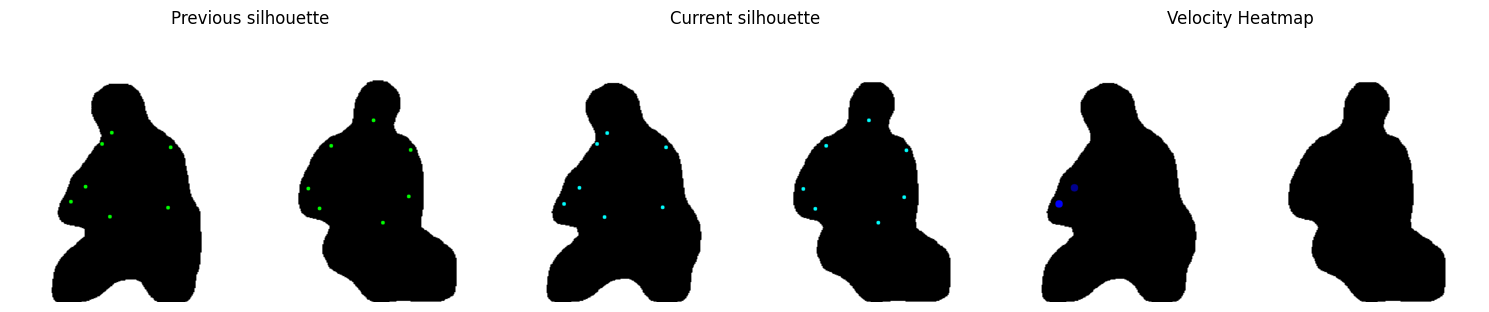

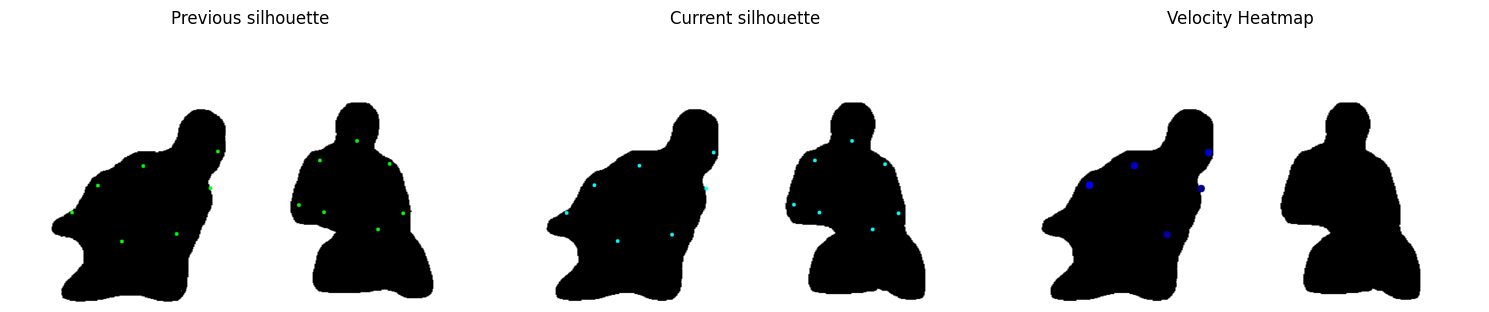

In [ ]:

def visualize_velocity_features(prev_frame_path, curr_frame_path, keypoint_path, step_size):

      # Load keypoints from JSON
    with open(keypoint_path, 'r') as f:
        keypoints_data = json.load(f)  # Load the nested structure

    # Convert the nested structure into a NumPy array
    frames = sorted(keypoints_data.keys(), key=lambda x: int(x))  # Sort frames
    persons = sorted(keypoints_data[frames[0]].keys(), key=lambda x: int(x))  # Sort persons
    num_frames = len(frames)
    num_persons = len(persons)
    num_keypoints = len(keypoints_data[frames[0]][persons[0]])  # Number of keypoints per person

    # Initialize a NumPy array to store keypoints
    keypoints = np.zeros((num_frames, num_persons, num_keypoints, 2))

    # Populate the keypoints array
    for frame_idx, frame in enumerate(frames):
        for person_idx, person in enumerate(persons):
            keypoints[frame_idx, person_idx] = keypoints_data[frame][person]

    # Reorder persons based on the sum of x-coordinates in the first frame
    sum_x_coords = np.sum(keypoints[0, :, :, 0], axis=1)
    reorder_indices = np.argsort(sum_x_coords)

    # Reorder keypoints array
    keypoints = keypoints[:, reorder_indices, :, :]
    keypoints = keypoints.reshape(num_frames, num_persons * num_keypoints, 2)

    total_frames = keypoints.shape[0]
    prev_frame_name = prev_frame_path.split('/')[-1]
    frame_dir = '/'.join(prev_frame_path.split('/')[:-1])

    total_files = sorted(os.listdir(frame_dir))
    prev_frame_pos = total_files.index(prev_frame_name)

    prev_keypoint = keypoints[prev_frame_pos]
    curr_keypoint = keypoints[prev_frame_pos + step_size]

    prev_frame = cv2.imread(prev_frame_path, cv2.IMREAD_GRAYSCALE)
    curr_frame = cv2.imread(curr_frame_path, cv2.IMREAD_GRAYSCALE)

    prev_frame = cv2.resize(prev_frame, (1280, 720))
    curr_frame = cv2.resize(curr_frame, (1280, 720))

    _, prev_frame = cv2.threshold(prev_frame, 0, 255, cv2.THRESH_BINARY_INV)
    _, curr_frame = cv2.threshold(curr_frame, 0, 255, cv2.THRESH_BINARY_INV)

    prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_GRAY2BGR)
    curr_frame = cv2.cvtColor(curr_frame, cv2.COLOR_GRAY2BGR)
    prev_frame_fig = prev_frame.copy()
    curr_frame_fig = curr_frame.copy()

    velocity = np.linalg.norm(curr_keypoint - prev_keypoint, axis=1)

    # visualize keypoints
    for x, y in prev_keypoint:
        cv2.circle(prev_frame, (int(x), int(y)), 5, (0, 255, 0), -1)

    for x, y in curr_keypoint:
        cv2.circle(curr_frame, (int(x), int(y)), 5, (255, 255, 0), -1)

    heatmap = curr_frame_fig.copy()
    norm_velocity = (velocity - velocity.min()) / (velocity.max() - velocity.min() + 1e-6)  # avoid divide by 0

    threshold = 0.5  # Skip keypoints with velocity less than 5% of max
    for (x, y), v in zip(curr_keypoint, norm_velocity):
        if v < threshold:
            continue  # Skip low-intensity keypoints
        intensity = int(255 * v)
        cv2.circle(heatmap, (int(x), int(y)), 10, (intensity, 0, 0), -1)  # Blue channel for velocity


    plt.figure(figsize=(15, 5))

    # Plot the previous silhouette
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB))
    plt.title("Previous silhouette")
    plt.axis('off')

    # Plot the curr sihouette
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB))
    plt.title("Current silhouette")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
    plt.title("Velocity Heatmap")
    plt.axis('off')
    # Display the figure
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    keypoints = []
    prev_frames = []
    curr_frames = []
    step_sizes = []

    # doing own work
    prev_frames.append("/content/drive/MyDrive/FYP/Silhouetes/42_1/74.png")
    curr_frames.append("/content/drive/MyDrive/FYP/Silhouetes/42_1/77.png")
    keypoints.append("/content/drive/MyDrive/FYP/keypoints/42_1.json")
    step_sizes.append(3)

    # looking at other's work
    prev_frames.append("/content/drive/MyDrive/FYP/Silhouetes/77_3/74.png")
    curr_frames.append("/content/drive/MyDrive/FYP/Silhouetes/77_3/75.png")
    keypoints.append("/content/drive/MyDrive/FYP/keypoints/77_3.json")
    step_sizes.append(1)


    for prev_frame_path, curr_frame_path, keypoint_path, step_size in zip(prev_frames, curr_frames, keypoints, step_sizes):
      visualize_velocity_features(prev_frame_path, curr_frame_path, keypoint_path, step_size)


## Distance features visualization code
This code displays distance features extracted from keypoints.

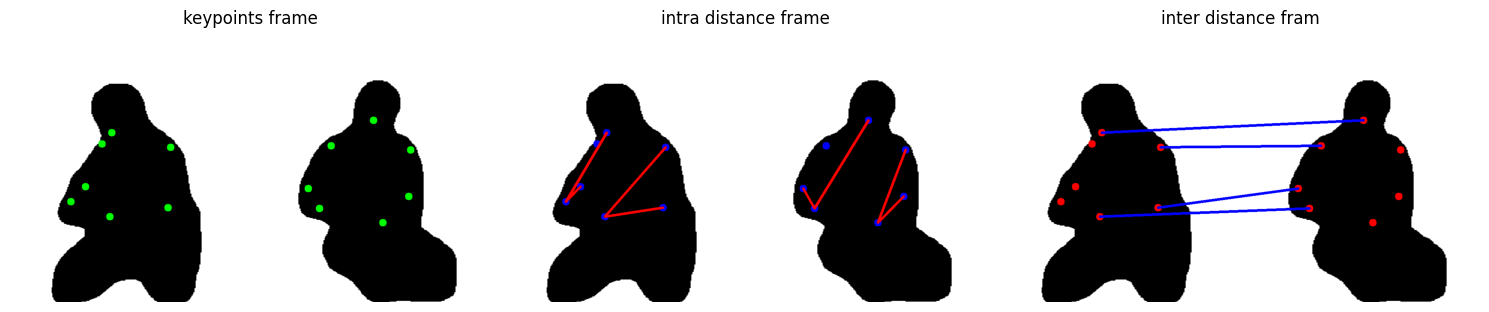

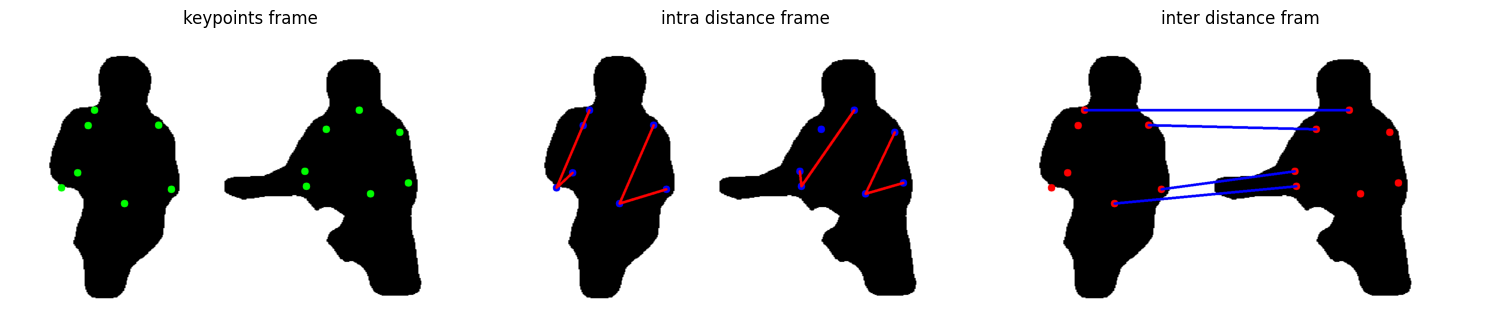

In [ ]:

indices = {
    'N1': 0, 'LS1': 1, 'RS1': 2, 'LE1': 3, 'RE1': 4,
    'LW1': 5, 'RW1': 6,
    'N2': 7, 'LS2': 8, 'RS2': 9, 'LE2': 10, 'RE2': 11,
    'LW2': 12, 'RW2': 13,
}


intra_distance_mapping = {
    "N1": ["RW1"],
    "LS1": ["LW1"],
    "RE1": ["RW1"],
    "LE1": ["LW1"],

     "N2": ["RW2"],
    "LS2": ["LW2"],
    "RE2": ["RW2"],
    "LE2": ["LW2"],
}

inter_distance_mapping = {
    "LS1": ["RS2"],
    "LW1": ["RW2"],
    "LE1": ["RE2"],
    "N1": ["N2"],
}


def visualize_distance_features(frame_path, keypoint_path):

    # Load keypoints from JSON
    with open(keypoint_path, 'r') as f:
        keypoints_data = json.load(f)  # Load the nested structure

    # Convert the nested structure into a NumPy array
    frames = sorted(keypoints_data.keys(), key=lambda x: int(x))  # Sort frames
    persons = sorted(keypoints_data[frames[0]].keys(), key=lambda x: int(x))  # Sort persons
    num_frames = len(frames)
    num_persons = len(persons)
    num_keypoints = len(keypoints_data[frames[0]][persons[0]])  # Number of keypoints per person

    # Initialize a NumPy array to store keypoints
    keypoints = np.zeros((num_frames, num_persons, num_keypoints, 2))  # (frames, persons, keypoints, coordinates)

    # Populate the keypoints array
    for frame_idx, frame in enumerate(frames):
        for person_idx, person in enumerate(persons):
            keypoints[frame_idx, person_idx] = keypoints_data[frame][person]

    # Reorder persons based on the sum of x-coordinates in the first frame
    sum_x_coords = np.sum(keypoints[0, :, :, 0], axis=1)  # Sum of x-coordinates for each person in the first frame
    reorder_indices = np.argsort(sum_x_coords)  # Indices to reorder persons

    # Reorder keypoints array
    keypoints = keypoints[:, reorder_indices, :, :]
    keypoints = keypoints.reshape(num_frames, num_persons * num_keypoints, 2)

    total_frames = keypoints.shape[0]
    frame_name = frame_path.split('/')[-1]
    frame_dir = '/'.join(frame_path.split('/')[:-1])

    total_files = sorted(os.listdir(frame_dir))
    frame_pos = total_files.index(frame_name)

    keypoint = keypoints[frame_pos]

    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    frame = cv2.resize(frame, (1280, 720))
    _, frame = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY_INV)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    keypoints_frame = frame.copy()
    intra_frame = frame.copy()
    inter_frame = frame.copy()

    # visualize keypoints
    for x, y in keypoint:
        cv2.circle(keypoints_frame, (int(x), int(y)), 10, (0, 255, 0), -1)
        cv2.circle(intra_frame, (int(x), int(y)), 10, (255, 0, 0), -1)
        cv2.circle(inter_frame, (int(x), int(y)), 10, (0, 0, 255), -1)

    # Draw intra distance
    for joint, connected_joints in intra_distance_mapping.items():
            start_point = (int(keypoint[indices[joint]][0]),
                              int(keypoint[indices[joint]][1]))
            if np.array_equal(start_point, [0, 0]):
               continue

            for connected_joint in connected_joints:
                end_point = (int(keypoint[indices[connected_joint]][0]),
                            int(keypoint[indices[connected_joint]][1]))
                if np.array_equal(end_point, [0, 0]):
                  continue
                cv2.line(intra_frame, start_point, end_point, (0, 0, 255), 5)  # Red line

    # Draw inter-distance blue lines
    for joint, connected_joints in inter_distance_mapping.items():
        start_point = (int(keypoint[indices[joint]][0]),
                          int(keypoint[indices[joint]][1]))
        if np.array_equal(start_point, [0, 0]):
          continue

        for connected_joint in connected_joints:
            end_point = (int(keypoint[indices[connected_joint]][0]),
                        int(keypoint[indices[connected_joint]][1]))
            if np.array_equal(end_point, [0, 0]):
              continue
            cv2.line(inter_frame, start_point, end_point, (255, 0, 0), 5)  # Blue line


    plt.figure(figsize=(15, 5))

    # Plot the previous silhouette
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(keypoints_frame, cv2.COLOR_BGR2RGB))
    plt.title("keypoints frame")
    plt.axis('off')

    # Plot the curr sihouette
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(intra_frame, cv2.COLOR_BGR2RGB))
    plt.title("intra distance frame")
    plt.axis('off')

    # Plot velocity features
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inter_frame, cv2.COLOR_BGR2RGB))
    plt.title("inter distance fram")
    plt.axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    keypoints = []
    frames = []

    # doing own work
    frames.append("/content/drive/MyDrive/FYP/Silhouetes/42_1/74.png")
    keypoints.append("/content/drive/MyDrive/FYP/keypoints/42_1.json")

    # passing paper
    frames.append("/content/drive/MyDrive/FYP/Silhouetes/87_2/53.png")
    keypoints.append("/content/drive/MyDrive/FYP/keypoints/87_2.json")


    for frame_path, keypoint_path in zip(frames, keypoints):
        visualize_distance_features(frame_path, keypoint_path)


## Angle features visualization code
This code displays angle features extracted from keypoints.

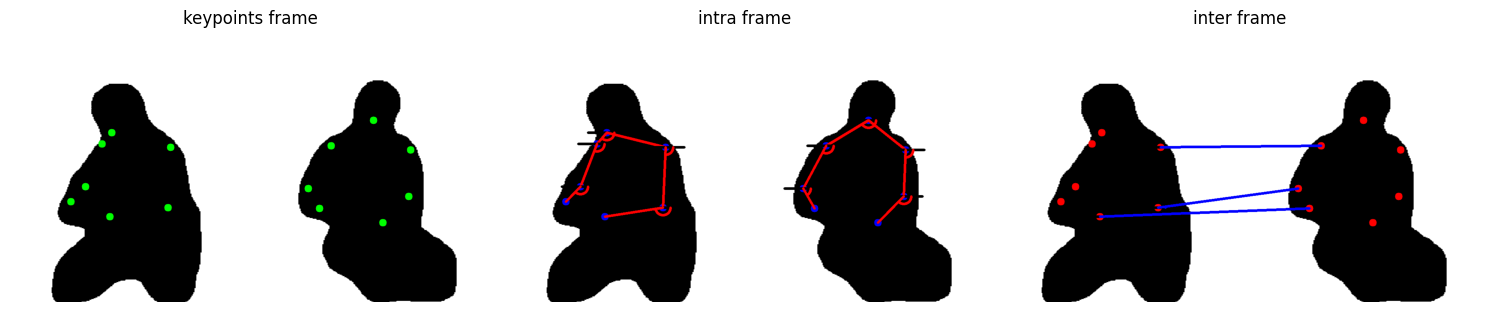

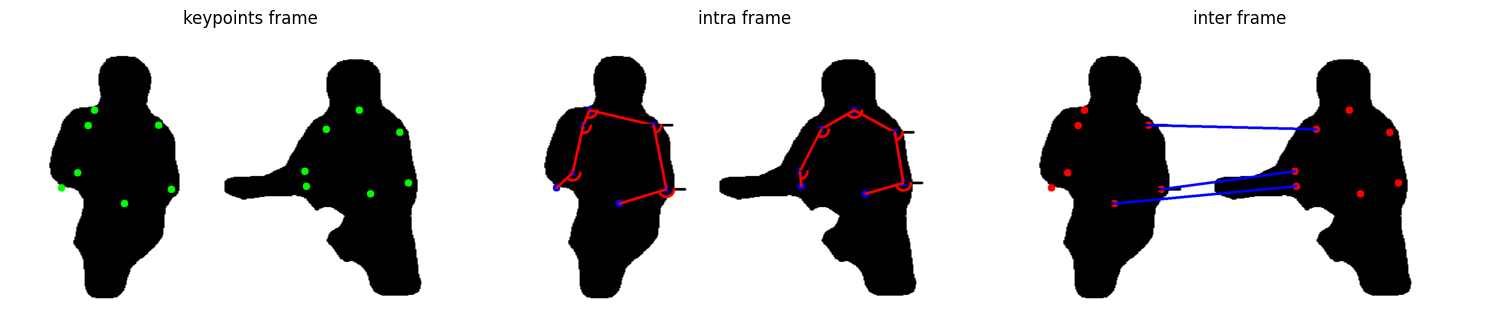

In [ ]:
import math

indices = {
    'N1': 0, 'LS1': 1, 'RS1': 2, 'LE1': 3, 'RE1': 4,
    'LW1': 5, 'RW1': 6,
    'N2': 7, 'LS2': 8, 'RS2': 9, 'LE2': 10, 'RE2': 11,
    'LW2': 12, 'RW2': 13,
}


intra_angle_mapping = {
    "N1": ["RS1", "LS1"],
    "RS1": ["RE1"],
    "LS1": ["LE1"],
    "RE1": ["RW1"],
    "LE1": ["LW1"],

    "N2": ["RS2", "LS2"],
    "RS2": ["RE2"],
    "LS2": ["LE2"],
    "RE2": ["RW2"],
    "LE2": ["LW2"]

}

inter_angle_mapping = {
    "LW1": ["RW2"],
    "LE1": ["RE2"],
    "LS1": ["RS2"]
}


def calculate_angle(start_point, end_point):
    delta_x = end_point[0] - start_point[0]
    delta_y = end_point[1] - start_point[1]
    angle = math.degrees(math.atan2(delta_y, delta_x))
    return angle

def visualize_angle_features(frame_path, keypoint_path):

    # Load keypoints from JSON
    with open(keypoint_path, 'r') as f:
        keypoints_data = json.load(f)  # Load the nested structure

    # Convert the nested structure into a NumPy array
    frames = sorted(keypoints_data.keys(), key=lambda x: int(x))  # Sort frames
    persons = sorted(keypoints_data[frames[0]].keys(), key=lambda x: int(x))  # Sort persons
    num_frames = len(frames)
    num_persons = len(persons)
    num_keypoints = len(keypoints_data[frames[0]][persons[0]])  # Number of keypoints per person

    # Initialize a NumPy array to store keypoints
    keypoints = np.zeros((num_frames, num_persons, num_keypoints, 2))  # (frames, persons, keypoints, coordinates)

    # Populate the keypoints array
    for frame_idx, frame in enumerate(frames):
        for person_idx, person in enumerate(persons):
            keypoints[frame_idx, person_idx] = keypoints_data[frame][person]

    # Reorder persons based on the sum of x-coordinates in the first frame
    sum_x_coords = np.sum(keypoints[0, :, :, 0], axis=1)  # Sum of x-coordinates for each person in the first frame
    reorder_indices = np.argsort(sum_x_coords)  # Indices to reorder persons

    # Reorder keypoints array
    keypoints = keypoints[:, reorder_indices, :, :]
    keypoints = keypoints.reshape(num_frames, num_persons * num_keypoints, 2)

    total_frames = keypoints.shape[0]
    frame_name = frame_path.split('/')[-1]
    frame_dir = '/'.join(frame_path.split('/')[:-1])

    total_files = sorted(os.listdir(frame_dir))
    frame_pos = total_files.index(frame_name)

    keypoint = keypoints[frame_pos]

    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    frame = cv2.resize(frame, (1280, 720))
    _, frame = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY_INV)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    keypoints_frame = frame.copy()
    intra_frame = frame.copy()
    inter_frame = frame.copy()

    # visualize keypoints
    for x, y in keypoint:
        cv2.circle(keypoints_frame, (int(x), int(y)), 10, (0, 255, 0), -1)
        cv2.circle(intra_frame, (int(x), int(y)), 10, (255, 0, 0), -1)
        cv2.circle(inter_frame, (int(x), int(y)), 10, (0, 0, 255), -1)


    # Draw angles with lines and arcs
    for joint, connected_joints in intra_angle_mapping.items():

        start_point = (int(keypoint[indices[joint]][0]),
                      int(keypoint[indices[joint]][1]))

        if np.array_equal(start_point, [0, 0]):
          continue

        # Base line through the joint (x-axis)
        base_line_end = (start_point[0] + 50, start_point[1])
        base_line_start = (start_point[0] - 50, start_point[1])
        cv2.line(intra_frame, base_line_start, base_line_end, (0, 0, 0), 5)  # Green base line

        for connected_joint in connected_joints:

            end_point = (int(keypoint[indices[connected_joint]][0]),
                        int(keypoint[indices[connected_joint]][1]))

            if np.array_equal(end_point, [0, 0]):
              continue

            # Draw the connecting line
            cv2.line(intra_frame, start_point, end_point, (0, 0, 255), 5)  # Red connecting line

            # Calculate angle between the base line and the connecting line
            angle = calculate_angle(start_point, end_point)

            # Draw the arc to represent the angle
            cv2.ellipse(intra_frame, start_point, (20, 20), 0, 0, angle, (0, 0, 255), 5)

     # Draw inter angles with lines and arcs
    for joint, connected_joints in inter_angle_mapping.items():

        start_point = (int(keypoint[indices[joint]][0]),
                      int(keypoint[indices[joint]][1]))

        if np.array_equal(start_point, [0, 0]):
          continue

        # Base line through the joint (x-axis)
        base_line_end = (start_point[0] + 50, start_point[1])
        base_line_start = (start_point[0] - 50, start_point[1])
        cv2.line(inter_frame, base_line_start, base_line_end, (0, 0, 0), 5)  # Green base line

        for connected_joint in connected_joints:
            end_point = (int(keypoint[indices[connected_joint]][0]),
                        int(keypoint[indices[connected_joint]][1]))

            if np.array_equal(end_point, [0, 0]):
              continue
            # Draw the connecting line
            cv2.line(inter_frame, start_point, end_point, (255, 0, 0), 5)  # Blue connecting line

            # Calculate angle between the base line and the connecting line
            angle = calculate_angle(start_point, end_point)

            # Draw the arc to represent the angle
            cv2.ellipse(inter_frame, start_point, (20, 20), 0, 0, angle, (255, 0, 0), 5)

    plt.figure(figsize=(15, 5))

    # Plot the previous silhouette
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(keypoints_frame, cv2.COLOR_BGR2RGB))
    plt.title("keypoints frame")
    plt.axis('off')

    # Plot the curr sihouette
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(intra_frame, cv2.COLOR_BGR2RGB))
    plt.title("intra frame")
    plt.axis('off')

    # Plot velocity features
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inter_frame, cv2.COLOR_BGR2RGB))
    plt.title("inter frame")
    plt.axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    keypoints = []
    frames = []

    # doing own work
    frames.append("/content/drive/MyDrive/FYP/Silhouetes/42_1/74.png")
    keypoints.append("/content/drive/MyDrive/FYP/keypoints/42_1.json")

    # passing paper
    frames.append("/content/drive/MyDrive/FYP/Silhouetes/87_2/53.png")
    keypoints.append("/content/drive/MyDrive/FYP/keypoints/87_2.json")

    for frame_path, keypoint_path in zip(frames, keypoints):
        visualize_angle_features(frame_path, keypoint_path)

